In [2]:
# Install libraries for data_loader
!pip install pandas
!pip install sklearn
#!pip install albumentations
!pip install torchvision
!pip install tqdm
!pip install torchmetrics

^C


In [4]:
# Import DataLoader and corresponding libraries
import pandas
import torchvision.transforms as TT
# import albumentations as T
# import albumentations.augmentations.transforms as T_transforms
# from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset, sampler
from sklearn.model_selection import StratifiedKFold
from torchvision import utils
from PIL import Image

In [5]:
# Import libraries for tensors
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# For fbeta-score
from torchmetrics.functional import fbeta_score

# For nn.Sequential
from collections import OrderedDict

In [6]:
# Import tqdm for progress bar construction
import tqdm

In [7]:
# Datatypes and Devices (from Assignment 2)
dtype = torch.float
ltype = torch.long

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cpu


In [8]:
# Hyper-parameters for K-Fold Cross Validation
N = 5
seed = 42

# Directories for Data
FF1010_Path = './birdnocall/'
AudioImage_Path = './image/'

In [9]:
# Call StratifiedKFold object
skf = StratifiedKFold(
    n_splits=5, shuffle=True, random_state=seed
)

In [10]:
# Modify dataframe for K-Fold Cross Validation (ff1010)
ff1010_csv = pandas.read_csv(FF1010_Path + 'metadata.csv')
ff1010_csv.loc[ff1010_csv['hasbird'] == 0, 'filepath'] = \
    FF1010_Path + 'nocall/' + ff1010_csv.query('hasbird == 0')['filename'] + '.npy'
ff1010_csv.loc[ff1010_csv['hasbird'] == 1, 'filepath'] = \
    FF1010_Path + 'bird/' + ff1010_csv.query('hasbird == 1')['filename'] + '.npy'
ff1010_csv.loc[ff1010_csv['duration'] == 7, 'filepath'] = \
    ff1010_csv.query('hasbird == 1')['fpath'] + '.npy'


ff1010_csv = ff1010_csv.dropna()
ff1010_csv = ff1010_csv.reset_index(drop=True)

# Add 'fold' attribute for dataset classification
ff1010_dataframe = ff1010_csv.copy()
for n, (_, nth_groups) in enumerate(
    skf.split(ff1010_dataframe, ff1010_dataframe['hasbird'])):
    ff1010_dataframe.loc[nth_groups, 'fold'] = int(n)

In [11]:
# Hyper-parameters for training 
ff1010_batch = 32
birdclef_batch = 32

In [12]:
# Class for ff1010 dataset
class FF1010(Dataset):
    def __init__(self, dataframe, process='train', labels='hasbird'):
        self.dataframe = dataframe
        self.filepaths = dataframe['filepath'].values
        self.labels = dataframe[labels].values
        self.process = process
        
        # Transforms for each train and validation
        self.train_transform = TT.Compose([
            TT.Resize([128, 281]),
            TT.RandomHorizontalFlip(p=0.5),
            TT.RandomVerticalFlip(p=0.5),
#             T_transforms.ImageCompression(p=0.5, 
#                 compression_type=T_transforms.ImageCompression.ImageCompressionType.JPEG),
#             T_transforms.ImageCompression(p=0.5, 
#                 compression_type=T_transforms.ImageCompression.ImageCompressionType.WEBP),
            TT.ToTensor(),
            TT.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])
        self.val_transform = TT.Compose([
            TT.Resize([128, 281]),
            TT.ToTensor(),
            TT.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])
    
    def __getitem__(self, idx):
        source = np.load(self.filepaths[idx])
        
        # Rearrange numpy arrays
        source = source.transpose(1, 2, 0)
        # Add RGB dimension
        source = np.stack((np.squeeze(source), ) * 3, -1)
        
        # Apply transform
        if self.process == 'train':
            source = self.train_transform(Image.fromarray(source))
        elif self.process == 'valid':
            source = self.val_transform(Image.fromarray(source))
        
        return source, torch.tensor(self.labels[idx], dtype=ltype).to(device)
    
    def __len__(self):
        return len(self.dataframe)

In [37]:
def evaluate_model(loader, model, beta):
    print("Checking accuracy score on validation set.")
    # TODO: extend this so that we can print that we evaluate test set.
    num_correct = 0
    num_samples = 0
    log_sum = 0
    fbeta_sum = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            # scores means classfication class for each class. It should be the tensor with size of (Input size, Number of classes)
            # In binary classification, it should be (batch size, 2) sized tensor

            # Checks naive accuracy.
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)

            # Checks Log Loss.
            log_loss = F.nll_loss(F.log_softmax(scores, dim=-1), y)
            log_sum += log_loss.sum() * preds.size(0)

            # Checks Fbeta-score.
            fbeta = fbeta_score(preds, y, beta=beta)
            fbeta_sum += fbeta * preds.size(0)

        acc = float(num_correct) / num_samples
        log_score = log_sum / num_samples
        f_score = fbeta_sum / num_samples
        print('\nAccuracy: %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        print('Log Loss score:\t%.2f' % (log_score))
        print('Fbeta-score (beta=%d): \t%.2f' % (beta , f_score))
    return acc, log_score, f_score

In [15]:
# Print period for accuracy.
print_period = 12

# Hyper-parameters for training 
ff1010_batch = 32
ff1010_epoch = 10

# Learning Rate.
learning_rate_1 = 0.001

# L2 Regularization Hyperparamter
weight_decay_1 = 0.001

# Beta constant for Fbeta-score.
# If you want to give more weight to precision, use value smaller than 1.0.
# If you want to give more weight to recall, use value larger than 1.0.
beta = 1.0

# Prototype of model 1.
# ResNet50 outputs (Batchsize, 1000) tensor as output, so we reduce them to 2.
# TODO: I'm curious about the output of the model: would output be the float number
#       between 0 and 1? If not, we need to add sigmoid or softmax function at the end.
model_1 = nn.Sequential(OrderedDict([
        ("resnet50", torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True).to(device)),
        ("relu", nn.ReLU().to(device)),
        ("linear", nn.Linear(1000, 2, bias=True).to(device)),
        ("softmax", nn.Softmax(dim=-1))
]))

print(model_1)

def train_model(model, train_loader, val_loader, optimizer, beta=beta, epoch=ff1010_epoch):
    val_losses = []
    train_losses = []
    epoch_losses = []
    log_scores = []
    fbeta_scores = []
    
    loss = 0
    log_score = 0
    for e in range(epoch):
        print(f"Training model 1, epoch {e+1}")
        for index, (source, label) in enumerate(tqdm.tqdm(train_loader)):
            x = source.to(device=device, dtype=torch.float)  # move to device, e.g. GPU
            y = label.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.nll_loss(F.log_softmax(scores, dim=-1), y) # Log loss for our project.
            epoch_losses.append(loss)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # every print_period, evaluate on val_loader.
            if index % print_period == 0:
                print('Iteration %d, loss = %.4f' % (index, loss.item()))
        acc, log_score, fbeta_score = evaluate_model(val_loader, model, beta=beta)
        val_losses.append(acc)
        epoch_losses = [t.double() for t in epoch_losses]
        train_losses.append(torch.tensor(sum(epoch_losses) / len(epoch_losses), dtype=dtype))
        log_scores.append(log_score)
        fbeta_scores.append(fbeta_score)

    return model, val_losses, train_losses, log_scores, fbeta_scores

Using cache found in C:\Users\ujubo/.cache\torch\hub\pytorch_vision_v0.10.0


Sequential(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [16]:
# from time import sleep

# Train loop for nocall detector
def nocall_train(model, train_dataframe, val_dataframe, test_dataframe):  
    train_data = FF1010(train_dataframe, process='train', labels='hasbird')
    val_data = FF1010(val_dataframe, process='valid', labels='hasbird')
    test_data = FF1010(test_dataframe, process='valid', labels='hasbird')
    
    # Construct data loader for train and validation
    train_loader = DataLoader(train_data, batch_size=ff1010_batch,
                             sampler=sampler.SubsetRandomSampler(range(len(train_dataframe))), 
                             drop_last=True)
    val_loader = DataLoader(val_data, batch_size=ff1010_batch,
                             sampler=sampler.SubsetRandomSampler(range(len(val_dataframe))),
                             drop_last=False)
    test_loader = DataLoader(test_data, batch_size=ff1010_batch,
                              sampler=sampler.SubsetRandomSampler(range(len(test_dataframe))),
                              drop_last=False)
    
    # Test for loaders
    
    optimizer = optim.SGD(model.parameters(), lr=learning_rate_1, momentum=0.5, weight_decay=weight_decay_1)
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate_1, weight_decay=weight_decay_1)
    trained_model, val_losses, train_losses, log_scores, fbeta_scores = train_model(
        model, train_loader, val_loader, optimizer, beta=beta)
    test_acc, test_log_score, test_fbeta_score = evaluate_model(test_loader, trained_model, beta=beta)
    
    return val_losses, train_losses, log_scores, fbeta_scores, [test_acc, test_log_score, test_fbeta_score]

In [17]:
# Train, Validate and Test for nocall detector
def nocall(model, dataframe, val_index, test_index):
    
    # Check that validation fold is not same as test fold
    assert val_index != test_index, \
        'Validation and test should be done on different fold.'
    print('Test set : %d, Validation set : %d' % (test_index, val_index))
    
    train_dataframe = dataframe.query(
        'fold != ' + str(val_index) + ' and fold != ' + str(test_index) 
    ).reset_index(drop=True)
    val_dataframe = dataframe.query(
        'fold == ' + str(val_index) 
    ).reset_index(drop=False)
    test_dataframe = dataframe.query(
        'fold == ' + str(test_index) 
    ).reset_index(drop=False)
    
    val_losses, train_losses, log_scores, fbeta_scores, test_scores = nocall_train(
        model, train_dataframe, val_dataframe, test_dataframe)

    return val_losses, train_losses, log_scores, fbeta_scores, test_scores

In [60]:
cur_model = nn.Sequential(OrderedDict([
    ("resnet50", torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True).to(device)),
    ("relu", nn.ReLU().to(device)),
    ("linear", nn.Linear(1000, 2, bias=True).to(device)),
    ("softmax", nn.Softmax(dim=-1))
]))
val_losses, train_losses, log_scores, fbeta_scores, test_scores = nocall(cur_model, ff1010_dataframe, 1, 0)

for i in range(2, 5):
    cur_model = nn.Sequential(OrderedDict([
        ("resnet50", torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True).to(device)),
        ("relu", nn.ReLU().to(device)),
        ("linear", nn.Linear(1000, 2, bias=True).to(device)),
        ("softmax", nn.Softmax(dim=-1))
    ]))
    cv_losses, ctr_losses, cl_scores, cf_scores, cte_scores = nocall(cur_model, ff1010_dataframe, i, 0)
    val_losses = torch.mean(torch.stack((torch.tensor(val_losses), torch.tensor(cv_losses))), dim=0)
    train_losses = torch.mean(torch.stack((torch.tensor(train_losses), torch.tensor(ctr_losses))), dim=0)
    log_scores = torch.mean(torch.stack((torch.tensor(log_scores), torch.tensor(cl_scores))), dim=0)
    fbeta_scores = torch.mean(torch.stack((torch.tensor(fbeta_scores), torch.tensor(cf_scores))), dim=0)
    for j in range(len(test_scores)):
        test_scores[j] = torch.mean(torch.stack((torch.tensor(test_scores[j]), torch.tensor(cte_scores[j]))), dim=0)

Using cache found in C:\Users\ujubo/.cache\torch\hub\pytorch_vision_v0.10.0


Test set : 0, Validation set : 1
Training model 1, epoch 1


  1%|▍                                                                                 | 1/189 [00:04<13:06,  4.18s/it]

Iteration 0, loss = 0.7394


  7%|█████▌                                                                           | 13/189 [00:55<12:25,  4.23s/it]

Iteration 12, loss = 0.6125


 13%|██████████▋                                                                      | 25/189 [01:46<11:35,  4.24s/it]

Iteration 24, loss = 0.6451


 20%|███████████████▊                                                                 | 37/189 [02:37<10:47,  4.26s/it]

Iteration 36, loss = 0.5900


 26%|█████████████████████                                                            | 49/189 [03:28<09:54,  4.25s/it]

Iteration 48, loss = 0.5441


 32%|██████████████████████████▏                                                      | 61/189 [04:19<09:07,  4.28s/it]

Iteration 60, loss = 0.4903


 39%|███████████████████████████████▎                                                 | 73/189 [05:10<08:12,  4.24s/it]

Iteration 72, loss = 0.5011


 45%|████████████████████████████████████▍                                            | 85/189 [06:01<07:21,  4.24s/it]

Iteration 84, loss = 0.4924


 51%|█████████████████████████████████████████▌                                       | 97/189 [06:52<06:31,  4.26s/it]

Iteration 96, loss = 0.5581


 58%|██████████████████████████████████████████████▏                                 | 109/189 [07:43<05:40,  4.25s/it]

Iteration 108, loss = 0.5306


 64%|███████████████████████████████████████████████████▏                            | 121/189 [08:34<04:49,  4.25s/it]

Iteration 120, loss = 0.4832


 70%|████████████████████████████████████████████████████████▎                       | 133/189 [09:25<03:58,  4.26s/it]

Iteration 132, loss = 0.5374


 77%|█████████████████████████████████████████████████████████████▍                  | 145/189 [10:16<03:07,  4.26s/it]

Iteration 144, loss = 0.4422


 83%|██████████████████████████████████████████████████████████████████▍             | 157/189 [11:07<02:16,  4.26s/it]

Iteration 156, loss = 0.5147


 89%|███████████████████████████████████████████████████████████████████████▌        | 169/189 [11:58<01:25,  4.26s/it]

Iteration 168, loss = 0.4539


 96%|████████████████████████████████████████████████████████████████████████████▌   | 181/189 [12:49<00:34,  4.25s/it]

Iteration 180, loss = 0.4162


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [13:23<00:00,  4.25s/it]


Checking accuracy score on validation set.


C:\Users\ujubo\AppData\Local\Temp/ipykernel_15484/9450484.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_losses.append(torch.tensor(sum(epoch_losses) / len(epoch_losses), dtype=dtype))



Accuracy: 1722 / 2021 correct (85.21)
Log Loss score:	0.47
Fbeta-score (beta=1): 	0.85
Training model 1, epoch 2


  1%|▍                                                                                 | 1/189 [00:04<12:47,  4.08s/it]

Iteration 0, loss = 0.4777


  7%|█████▌                                                                           | 13/189 [00:53<11:59,  4.09s/it]

Iteration 12, loss = 0.4661


 13%|██████████▋                                                                      | 25/189 [01:42<11:15,  4.12s/it]

Iteration 24, loss = 0.3989


 20%|███████████████▊                                                                 | 37/189 [02:31<10:20,  4.08s/it]

Iteration 36, loss = 0.4181


 26%|█████████████████████                                                            | 49/189 [03:20<09:32,  4.09s/it]

Iteration 48, loss = 0.4229


 32%|██████████████████████████▏                                                      | 61/189 [04:09<08:44,  4.09s/it]

Iteration 60, loss = 0.4678


 39%|███████████████████████████████▎                                                 | 73/189 [04:58<07:54,  4.09s/it]

Iteration 72, loss = 0.4089


 45%|████████████████████████████████████▍                                            | 85/189 [05:47<07:04,  4.08s/it]

Iteration 84, loss = 0.4363


 51%|█████████████████████████████████████████▌                                       | 97/189 [06:36<06:15,  4.08s/it]

Iteration 96, loss = 0.3327


 58%|██████████████████████████████████████████████▏                                 | 109/189 [07:25<05:25,  4.07s/it]

Iteration 108, loss = 0.5459


 64%|███████████████████████████████████████████████████▏                            | 121/189 [08:14<04:38,  4.10s/it]

Iteration 120, loss = 0.4241


 70%|████████████████████████████████████████████████████████▎                       | 133/189 [09:03<03:47,  4.06s/it]

Iteration 132, loss = 0.4656


 77%|█████████████████████████████████████████████████████████████▍                  | 145/189 [09:53<02:59,  4.08s/it]

Iteration 144, loss = 0.3902


 83%|██████████████████████████████████████████████████████████████████▍             | 157/189 [10:42<02:10,  4.09s/it]

Iteration 156, loss = 0.3385


 89%|███████████████████████████████████████████████████████████████████████▌        | 169/189 [11:30<01:21,  4.06s/it]

Iteration 168, loss = 0.3518


 96%|████████████████████████████████████████████████████████████████████████████▌   | 181/189 [12:19<00:32,  4.08s/it]

Iteration 180, loss = 0.4089


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [12:52<00:00,  4.09s/it]


Checking accuracy score on validation set.

Accuracy: 1800 / 2021 correct (89.06)
Log Loss score:	0.42
Fbeta-score (beta=1): 	0.89
Training model 1, epoch 3


  1%|▍                                                                                 | 1/189 [00:04<12:53,  4.11s/it]

Iteration 0, loss = 0.4212


  7%|█████▌                                                                           | 13/189 [00:53<11:59,  4.09s/it]

Iteration 12, loss = 0.3473


 13%|██████████▋                                                                      | 25/189 [01:42<11:10,  4.09s/it]

Iteration 24, loss = 0.5975


 20%|███████████████▊                                                                 | 37/189 [02:31<10:24,  4.11s/it]

Iteration 36, loss = 0.3960


 26%|█████████████████████                                                            | 49/189 [03:20<09:34,  4.10s/it]

Iteration 48, loss = 0.5110


 32%|██████████████████████████▏                                                      | 61/189 [04:09<08:43,  4.09s/it]

Iteration 60, loss = 0.3630


 39%|███████████████████████████████▎                                                 | 73/189 [04:58<07:56,  4.11s/it]

Iteration 72, loss = 0.3913


 45%|████████████████████████████████████▍                                            | 85/189 [05:47<07:04,  4.09s/it]

Iteration 84, loss = 0.3644


 51%|█████████████████████████████████████████▌                                       | 97/189 [06:37<06:16,  4.09s/it]

Iteration 96, loss = 0.3475


 58%|██████████████████████████████████████████████▏                                 | 109/189 [07:26<05:27,  4.09s/it]

Iteration 108, loss = 0.5053


 64%|███████████████████████████████████████████████████▏                            | 121/189 [08:15<04:38,  4.10s/it]

Iteration 120, loss = 0.3690


 70%|████████████████████████████████████████████████████████▎                       | 133/189 [09:04<03:48,  4.08s/it]

Iteration 132, loss = 0.4759


 77%|█████████████████████████████████████████████████████████████▍                  | 145/189 [09:53<02:59,  4.08s/it]

Iteration 144, loss = 0.3386


 83%|██████████████████████████████████████████████████████████████████▍             | 157/189 [10:42<02:10,  4.08s/it]

Iteration 156, loss = 0.3489


 89%|███████████████████████████████████████████████████████████████████████▌        | 169/189 [11:31<01:21,  4.08s/it]

Iteration 168, loss = 0.3977


 96%|████████████████████████████████████████████████████████████████████████████▌   | 181/189 [12:20<00:32,  4.08s/it]

Iteration 180, loss = 0.5141


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [12:53<00:00,  4.09s/it]


Checking accuracy score on validation set.

Accuracy: 1809 / 2021 correct (89.51)
Log Loss score:	0.42
Fbeta-score (beta=1): 	0.90
Training model 1, epoch 4


  1%|▍                                                                                 | 1/189 [00:04<12:47,  4.08s/it]

Iteration 0, loss = 0.3706


  7%|█████▌                                                                           | 13/189 [00:53<12:00,  4.09s/it]

Iteration 12, loss = 0.4081


 13%|██████████▋                                                                      | 25/189 [01:42<11:09,  4.08s/it]

Iteration 24, loss = 0.4259


 20%|███████████████▊                                                                 | 37/189 [02:31<10:23,  4.10s/it]

Iteration 36, loss = 0.4671


 26%|█████████████████████                                                            | 49/189 [03:20<09:31,  4.08s/it]

Iteration 48, loss = 0.4715


 32%|██████████████████████████▏                                                      | 61/189 [04:08<08:42,  4.08s/it]

Iteration 60, loss = 0.4431


 39%|███████████████████████████████▎                                                 | 73/189 [04:58<07:55,  4.10s/it]

Iteration 72, loss = 0.4473


 45%|████████████████████████████████████▍                                            | 85/189 [05:47<07:03,  4.07s/it]

Iteration 84, loss = 0.4442


 51%|█████████████████████████████████████████▌                                       | 97/189 [06:36<06:16,  4.09s/it]

Iteration 96, loss = 0.3597


 58%|██████████████████████████████████████████████▏                                 | 109/189 [07:24<05:25,  4.07s/it]

Iteration 108, loss = 0.4503


 64%|███████████████████████████████████████████████████▏                            | 121/189 [08:13<04:37,  4.08s/it]

Iteration 120, loss = 0.4769


 70%|████████████████████████████████████████████████████████▎                       | 133/189 [09:02<03:48,  4.08s/it]

Iteration 132, loss = 0.4377


 77%|█████████████████████████████████████████████████████████████▍                  | 145/189 [09:51<02:59,  4.07s/it]

Iteration 144, loss = 0.4281


 83%|██████████████████████████████████████████████████████████████████▍             | 157/189 [10:40<02:11,  4.11s/it]

Iteration 156, loss = 0.4725


 89%|███████████████████████████████████████████████████████████████████████▌        | 169/189 [11:29<01:21,  4.07s/it]

Iteration 168, loss = 0.3303


 96%|████████████████████████████████████████████████████████████████████████████▌   | 181/189 [12:18<00:32,  4.07s/it]

Iteration 180, loss = 0.4971


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [12:51<00:00,  4.08s/it]


Checking accuracy score on validation set.

Accuracy: 1782 / 2021 correct (88.17)
Log Loss score:	0.43
Fbeta-score (beta=1): 	0.88
Training model 1, epoch 5


  1%|▍                                                                                 | 1/189 [00:04<12:45,  4.07s/it]

Iteration 0, loss = 0.4191


  7%|█████▌                                                                           | 13/189 [00:52<11:57,  4.07s/it]

Iteration 12, loss = 0.4279


 13%|██████████▋                                                                      | 25/189 [01:41<11:11,  4.09s/it]

Iteration 24, loss = 0.3838


 20%|███████████████▊                                                                 | 37/189 [02:30<10:23,  4.10s/it]

Iteration 36, loss = 0.4408


 26%|█████████████████████                                                            | 49/189 [03:20<09:32,  4.09s/it]

Iteration 48, loss = 0.4944


 32%|██████████████████████████▏                                                      | 61/189 [04:08<08:42,  4.08s/it]

Iteration 60, loss = 0.3764


 39%|███████████████████████████████▎                                                 | 73/189 [04:57<07:53,  4.08s/it]

Iteration 72, loss = 0.3906


 45%|████████████████████████████████████▍                                            | 85/189 [05:46<07:04,  4.08s/it]

Iteration 84, loss = 0.3619


 51%|█████████████████████████████████████████▌                                       | 97/189 [06:35<06:16,  4.09s/it]

Iteration 96, loss = 0.4065


 58%|██████████████████████████████████████████████▏                                 | 109/189 [07:24<05:26,  4.09s/it]

Iteration 108, loss = 0.4926


 64%|███████████████████████████████████████████████████▏                            | 121/189 [08:14<04:38,  4.09s/it]

Iteration 120, loss = 0.4226


 70%|████████████████████████████████████████████████████████▎                       | 133/189 [09:03<03:48,  4.08s/it]

Iteration 132, loss = 0.3968


 77%|█████████████████████████████████████████████████████████████▍                  | 145/189 [09:52<02:59,  4.08s/it]

Iteration 144, loss = 0.3803


 83%|██████████████████████████████████████████████████████████████████▍             | 157/189 [10:41<02:10,  4.07s/it]

Iteration 156, loss = 0.4121


 89%|███████████████████████████████████████████████████████████████████████▌        | 169/189 [11:30<01:21,  4.09s/it]

Iteration 168, loss = 0.4632


 96%|████████████████████████████████████████████████████████████████████████████▌   | 181/189 [12:19<00:32,  4.09s/it]

Iteration 180, loss = 0.6068


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [12:52<00:00,  4.09s/it]


Checking accuracy score on validation set.

Accuracy: 1797 / 2021 correct (88.92)
Log Loss score:	0.42
Fbeta-score (beta=1): 	0.89
Training model 1, epoch 6


  1%|▍                                                                                 | 1/189 [00:04<13:12,  4.22s/it]

Iteration 0, loss = 0.4065


  7%|█████▌                                                                           | 13/189 [00:54<12:11,  4.15s/it]

Iteration 12, loss = 0.3797


 13%|██████████▋                                                                      | 25/189 [01:46<12:34,  4.60s/it]

Iteration 24, loss = 0.3174


 20%|███████████████▊                                                                 | 37/189 [02:39<11:03,  4.37s/it]

Iteration 36, loss = 0.5687


 26%|█████████████████████                                                            | 49/189 [03:31<10:05,  4.33s/it]

Iteration 48, loss = 0.4624


 32%|██████████████████████████▏                                                      | 61/189 [04:23<09:13,  4.32s/it]

Iteration 60, loss = 0.4140


 39%|███████████████████████████████▎                                                 | 73/189 [05:15<08:18,  4.29s/it]

Iteration 72, loss = 0.3974


 45%|████████████████████████████████████▍                                            | 85/189 [06:07<07:33,  4.36s/it]

Iteration 84, loss = 0.4165


 51%|█████████████████████████████████████████▌                                       | 97/189 [07:00<06:49,  4.45s/it]

Iteration 96, loss = 0.4072


 58%|██████████████████████████████████████████████▏                                 | 109/189 [07:53<05:53,  4.42s/it]

Iteration 108, loss = 0.4679


 64%|███████████████████████████████████████████████████▏                            | 121/189 [08:47<05:03,  4.47s/it]

Iteration 120, loss = 0.3466


 70%|████████████████████████████████████████████████████████▎                       | 133/189 [09:40<04:07,  4.42s/it]

Iteration 132, loss = 0.3603


 77%|█████████████████████████████████████████████████████████████▍                  | 145/189 [10:33<03:15,  4.44s/it]

Iteration 144, loss = 0.4707


 83%|██████████████████████████████████████████████████████████████████▍             | 157/189 [11:26<02:22,  4.45s/it]

Iteration 156, loss = 0.4514


 89%|███████████████████████████████████████████████████████████████████████▌        | 169/189 [12:19<01:28,  4.42s/it]

Iteration 168, loss = 0.3299


 96%|████████████████████████████████████████████████████████████████████████████▌   | 181/189 [13:12<00:35,  4.41s/it]

Iteration 180, loss = 0.4348


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [13:48<00:00,  4.38s/it]


Checking accuracy score on validation set.

Accuracy: 1817 / 2021 correct (89.91)
Log Loss score:	0.41
Fbeta-score (beta=1): 	0.90
Training model 1, epoch 7


  1%|▍                                                                                 | 1/189 [00:04<13:44,  4.38s/it]

Iteration 0, loss = 0.4211


  7%|█████▌                                                                           | 13/189 [00:57<12:54,  4.40s/it]

Iteration 12, loss = 0.3510


 13%|██████████▋                                                                      | 25/189 [01:50<12:06,  4.43s/it]

Iteration 24, loss = 0.3259


 20%|███████████████▊                                                                 | 37/189 [02:43<11:09,  4.41s/it]

Iteration 36, loss = 0.4843


 26%|█████████████████████                                                            | 49/189 [03:36<10:20,  4.43s/it]

Iteration 48, loss = 0.3994


 32%|██████████████████████████▏                                                      | 61/189 [04:29<09:24,  4.41s/it]

Iteration 60, loss = 0.4718


 39%|███████████████████████████████▎                                                 | 73/189 [05:22<08:34,  4.43s/it]

Iteration 72, loss = 0.4486


 45%|████████████████████████████████████▍                                            | 85/189 [06:15<07:40,  4.43s/it]

Iteration 84, loss = 0.3656


 51%|█████████████████████████████████████████▌                                       | 97/189 [07:09<06:48,  4.44s/it]

Iteration 96, loss = 0.3788


 58%|██████████████████████████████████████████████▏                                 | 109/189 [08:02<05:54,  4.43s/it]

Iteration 108, loss = 0.4075


 64%|███████████████████████████████████████████████████▏                            | 121/189 [08:55<04:59,  4.41s/it]

Iteration 120, loss = 0.3971


 70%|████████████████████████████████████████████████████████▎                       | 133/189 [09:48<04:07,  4.42s/it]

Iteration 132, loss = 0.3835


 77%|█████████████████████████████████████████████████████████████▍                  | 145/189 [10:41<03:13,  4.40s/it]

Iteration 144, loss = 0.4370


 83%|██████████████████████████████████████████████████████████████████▍             | 157/189 [11:34<02:21,  4.43s/it]

Iteration 156, loss = 0.3862


 89%|███████████████████████████████████████████████████████████████████████▌        | 169/189 [12:27<01:28,  4.42s/it]

Iteration 168, loss = 0.3517


 96%|████████████████████████████████████████████████████████████████████████████▌   | 181/189 [13:20<00:35,  4.42s/it]

Iteration 180, loss = 0.3599


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [13:55<00:00,  4.42s/it]


Checking accuracy score on validation set.

Accuracy: 1827 / 2021 correct (90.40)
Log Loss score:	0.41
Fbeta-score (beta=1): 	0.90
Training model 1, epoch 8


  1%|▍                                                                                 | 1/189 [00:04<14:24,  4.60s/it]

Iteration 0, loss = 0.4014


  7%|█████▌                                                                           | 13/189 [00:56<12:39,  4.32s/it]

Iteration 12, loss = 0.4040


 13%|██████████▋                                                                      | 25/189 [01:50<12:29,  4.57s/it]

Iteration 24, loss = 0.3449


 20%|███████████████▊                                                                 | 37/189 [02:44<11:18,  4.46s/it]

Iteration 36, loss = 0.3997


 26%|█████████████████████                                                            | 49/189 [03:37<10:25,  4.47s/it]

Iteration 48, loss = 0.4438


 32%|██████████████████████████▏                                                      | 61/189 [04:31<09:31,  4.47s/it]

Iteration 60, loss = 0.3844


 39%|███████████████████████████████▎                                                 | 73/189 [05:24<08:34,  4.44s/it]

Iteration 72, loss = 0.4174


 45%|████████████████████████████████████▍                                            | 85/189 [06:18<07:43,  4.45s/it]

Iteration 84, loss = 0.3775


 51%|█████████████████████████████████████████▌                                       | 97/189 [07:11<06:48,  4.44s/it]

Iteration 96, loss = 0.3823


 58%|██████████████████████████████████████████████▏                                 | 109/189 [08:04<05:56,  4.45s/it]

Iteration 108, loss = 0.3457


 64%|███████████████████████████████████████████████████▏                            | 121/189 [08:58<05:03,  4.46s/it]

Iteration 120, loss = 0.4480


 70%|████████████████████████████████████████████████████████▎                       | 133/189 [09:51<04:08,  4.44s/it]

Iteration 132, loss = 0.3980


 77%|█████████████████████████████████████████████████████████████▍                  | 145/189 [10:44<03:15,  4.44s/it]

Iteration 144, loss = 0.4578


 83%|██████████████████████████████████████████████████████████████████▍             | 157/189 [11:38<02:22,  4.46s/it]

Iteration 156, loss = 0.3513


 89%|███████████████████████████████████████████████████████████████████████▌        | 169/189 [12:31<01:29,  4.45s/it]

Iteration 168, loss = 0.3465


 96%|████████████████████████████████████████████████████████████████████████████▌   | 181/189 [13:25<00:35,  4.46s/it]

Iteration 180, loss = 0.4364


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [14:00<00:00,  4.45s/it]


Checking accuracy score on validation set.

Accuracy: 1815 / 2021 correct (89.81)
Log Loss score:	0.41
Fbeta-score (beta=1): 	0.90
Training model 1, epoch 9


  1%|▍                                                                                 | 1/189 [00:04<13:47,  4.40s/it]

Iteration 0, loss = 0.3146


  7%|█████▌                                                                           | 13/189 [00:57<12:59,  4.43s/it]

Iteration 12, loss = 0.4558


 13%|██████████▋                                                                      | 25/189 [01:51<12:13,  4.47s/it]

Iteration 24, loss = 0.3539


 20%|███████████████▊                                                                 | 37/189 [02:44<11:18,  4.47s/it]

Iteration 36, loss = 0.3808


 26%|█████████████████████                                                            | 49/189 [03:38<10:21,  4.44s/it]

Iteration 48, loss = 0.3945


 32%|██████████████████████████▏                                                      | 61/189 [04:31<09:28,  4.44s/it]

Iteration 60, loss = 0.3449


 39%|███████████████████████████████▎                                                 | 73/189 [05:25<08:37,  4.46s/it]

Iteration 72, loss = 0.4333


 45%|████████████████████████████████████▍                                            | 85/189 [06:18<07:41,  4.44s/it]

Iteration 84, loss = 0.4462


 51%|█████████████████████████████████████████▌                                       | 97/189 [07:12<06:50,  4.46s/it]

Iteration 96, loss = 0.3581


 58%|██████████████████████████████████████████████▏                                 | 109/189 [08:05<05:57,  4.46s/it]

Iteration 108, loss = 0.4101


 64%|███████████████████████████████████████████████████▏                            | 121/189 [08:59<05:02,  4.45s/it]

Iteration 120, loss = 0.4500


 70%|████████████████████████████████████████████████████████▎                       | 133/189 [09:53<04:09,  4.45s/it]

Iteration 132, loss = 0.4565


 77%|█████████████████████████████████████████████████████████████▍                  | 145/189 [10:46<03:15,  4.45s/it]

Iteration 144, loss = 0.3420


 83%|██████████████████████████████████████████████████████████████████▍             | 157/189 [11:40<02:23,  4.49s/it]

Iteration 156, loss = 0.3760


 89%|███████████████████████████████████████████████████████████████████████▌        | 169/189 [12:33<01:29,  4.47s/it]

Iteration 168, loss = 0.3993


 96%|████████████████████████████████████████████████████████████████████████████▌   | 181/189 [13:27<00:35,  4.40s/it]

Iteration 180, loss = 0.3754


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [14:02<00:00,  4.46s/it]


Checking accuracy score on validation set.

Accuracy: 1826 / 2021 correct (90.35)
Log Loss score:	0.41
Fbeta-score (beta=1): 	0.90
Training model 1, epoch 10


  1%|▍                                                                                 | 1/189 [00:04<13:23,  4.27s/it]

Iteration 0, loss = 0.4620


  7%|█████▌                                                                           | 13/189 [00:56<12:49,  4.37s/it]

Iteration 12, loss = 0.3436


 13%|██████████▋                                                                      | 25/189 [01:49<11:48,  4.32s/it]

Iteration 24, loss = 0.4349


 20%|███████████████▊                                                                 | 37/189 [02:42<11:22,  4.49s/it]

Iteration 36, loss = 0.4844


 26%|█████████████████████                                                            | 49/189 [03:36<10:30,  4.51s/it]

Iteration 48, loss = 0.3557


 32%|██████████████████████████▏                                                      | 61/189 [04:30<09:35,  4.49s/it]

Iteration 60, loss = 0.3224


 39%|███████████████████████████████▎                                                 | 73/189 [05:24<08:41,  4.50s/it]

Iteration 72, loss = 0.3474


 45%|████████████████████████████████████▍                                            | 85/189 [06:18<07:46,  4.48s/it]

Iteration 84, loss = 0.3764


 51%|█████████████████████████████████████████▌                                       | 97/189 [07:12<06:51,  4.48s/it]

Iteration 96, loss = 0.3487


 58%|██████████████████████████████████████████████▏                                 | 109/189 [08:05<05:56,  4.46s/it]

Iteration 108, loss = 0.4295


 64%|███████████████████████████████████████████████████▏                            | 121/189 [08:59<05:04,  4.48s/it]

Iteration 120, loss = 0.3496


 70%|████████████████████████████████████████████████████████▎                       | 133/189 [09:53<04:11,  4.48s/it]

Iteration 132, loss = 0.4114


 77%|█████████████████████████████████████████████████████████████▍                  | 145/189 [10:46<03:17,  4.48s/it]

Iteration 144, loss = 0.3528


 83%|██████████████████████████████████████████████████████████████████▍             | 157/189 [11:40<02:23,  4.48s/it]

Iteration 156, loss = 0.3164


 89%|███████████████████████████████████████████████████████████████████████▌        | 169/189 [12:34<01:29,  4.46s/it]

Iteration 168, loss = 0.3532


 96%|████████████████████████████████████████████████████████████████████████████▌   | 181/189 [13:28<00:35,  4.48s/it]

Iteration 180, loss = 0.3695


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [14:04<00:00,  4.47s/it]


Checking accuracy score on validation set.

Accuracy: 1843 / 2021 correct (91.19)
Log Loss score:	0.40
Fbeta-score (beta=1): 	0.91
Checking accuracy score on validation set.

Accuracy: 1834 / 2021 correct (90.75)
Log Loss score:	0.41
Fbeta-score (beta=1): 	0.91


Using cache found in C:\Users\ujubo/.cache\torch\hub\pytorch_vision_v0.10.0


Test set : 0, Validation set : 2
Training model 1, epoch 1


  1%|▍                                                                                 | 1/189 [00:04<14:15,  4.55s/it]

Iteration 0, loss = 0.7136


  7%|█████▌                                                                           | 13/189 [00:59<13:27,  4.59s/it]

Iteration 12, loss = 0.5925


 13%|██████████▋                                                                      | 25/189 [01:54<12:33,  4.60s/it]

Iteration 24, loss = 0.6472


 20%|███████████████▊                                                                 | 37/189 [02:50<11:33,  4.56s/it]

Iteration 36, loss = 0.6575


 26%|█████████████████████                                                            | 49/189 [03:45<10:47,  4.63s/it]

Iteration 48, loss = 0.6089


 32%|██████████████████████████▏                                                      | 61/189 [04:40<09:47,  4.59s/it]

Iteration 60, loss = 0.5261


 39%|███████████████████████████████▎                                                 | 73/189 [05:35<08:49,  4.56s/it]

Iteration 72, loss = 0.6080


 45%|████████████████████████████████████▍                                            | 85/189 [06:30<08:00,  4.62s/it]

Iteration 84, loss = 0.5463


 51%|█████████████████████████████████████████▌                                       | 97/189 [07:26<07:03,  4.60s/it]

Iteration 96, loss = 0.5239


 58%|██████████████████████████████████████████████▏                                 | 109/189 [08:21<06:08,  4.60s/it]

Iteration 108, loss = 0.4399


 64%|███████████████████████████████████████████████████▏                            | 121/189 [09:15<05:00,  4.42s/it]

Iteration 120, loss = 0.5516


 70%|████████████████████████████████████████████████████████▎                       | 133/189 [10:09<04:15,  4.56s/it]

Iteration 132, loss = 0.4598


 77%|█████████████████████████████████████████████████████████████▍                  | 145/189 [11:03<03:13,  4.39s/it]

Iteration 144, loss = 0.4342


 83%|██████████████████████████████████████████████████████████████████▍             | 157/189 [11:56<02:19,  4.37s/it]

Iteration 156, loss = 0.4647


 89%|███████████████████████████████████████████████████████████████████████▌        | 169/189 [12:48<01:27,  4.38s/it]

Iteration 168, loss = 0.5206


 96%|████████████████████████████████████████████████████████████████████████████▌   | 181/189 [13:40<00:34,  4.35s/it]

Iteration 180, loss = 0.5272


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [14:15<00:00,  4.53s/it]


Checking accuracy score on validation set.

Accuracy: 1743 / 2021 correct (86.24)
Log Loss score:	0.46
Fbeta-score (beta=1): 	0.86
Training model 1, epoch 2


  1%|▍                                                                                 | 1/189 [00:04<13:37,  4.35s/it]

Iteration 0, loss = 0.4746


  7%|█████▌                                                                           | 13/189 [00:55<12:32,  4.27s/it]

Iteration 12, loss = 0.4161


 13%|██████████▋                                                                      | 25/189 [01:46<11:38,  4.26s/it]

Iteration 24, loss = 0.4734


 20%|███████████████▊                                                                 | 37/189 [02:38<10:59,  4.34s/it]

Iteration 36, loss = 0.4439


 26%|█████████████████████                                                            | 49/189 [03:30<10:12,  4.37s/it]

Iteration 48, loss = 0.4530


 32%|██████████████████████████▏                                                      | 61/189 [04:21<09:02,  4.24s/it]

Iteration 60, loss = 0.4190


 39%|███████████████████████████████▎                                                 | 73/189 [05:12<08:08,  4.21s/it]

Iteration 72, loss = 0.5168


 45%|████████████████████████████████████▍                                            | 85/189 [06:02<07:23,  4.26s/it]

Iteration 84, loss = 0.4516


 51%|█████████████████████████████████████████▌                                       | 97/189 [06:54<06:32,  4.27s/it]

Iteration 96, loss = 0.3668


 58%|██████████████████████████████████████████████▏                                 | 109/189 [07:45<05:39,  4.25s/it]

Iteration 108, loss = 0.4891


 64%|███████████████████████████████████████████████████▏                            | 121/189 [08:36<04:57,  4.38s/it]

Iteration 120, loss = 0.4299


 70%|████████████████████████████████████████████████████████▎                       | 133/189 [09:28<04:01,  4.31s/it]

Iteration 132, loss = 0.4069


 77%|█████████████████████████████████████████████████████████████▍                  | 145/189 [10:20<03:11,  4.35s/it]

Iteration 144, loss = 0.4119


 83%|██████████████████████████████████████████████████████████████████▍             | 157/189 [11:10<02:11,  4.12s/it]

Iteration 156, loss = 0.4663


 89%|███████████████████████████████████████████████████████████████████████▌        | 169/189 [12:00<01:22,  4.11s/it]

Iteration 168, loss = 0.4708


 96%|████████████████████████████████████████████████████████████████████████████▌   | 181/189 [12:49<00:32,  4.09s/it]

Iteration 180, loss = 0.4592


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [13:21<00:00,  4.24s/it]


Checking accuracy score on validation set.

Accuracy: 1804 / 2021 correct (89.26)
Log Loss score:	0.42
Fbeta-score (beta=1): 	0.89
Training model 1, epoch 3


  1%|▍                                                                                 | 1/189 [00:04<12:42,  4.06s/it]

Iteration 0, loss = 0.5191


  7%|█████▌                                                                           | 13/189 [00:53<11:56,  4.07s/it]

Iteration 12, loss = 0.3502


 13%|██████████▋                                                                      | 25/189 [01:42<11:16,  4.13s/it]

Iteration 24, loss = 0.3921


 20%|███████████████▊                                                                 | 37/189 [02:31<10:21,  4.09s/it]

Iteration 36, loss = 0.4146


 26%|█████████████████████                                                            | 49/189 [03:20<09:30,  4.08s/it]

Iteration 48, loss = 0.3595


 32%|██████████████████████████▏                                                      | 61/189 [04:09<08:42,  4.08s/it]

Iteration 60, loss = 0.4471


 39%|███████████████████████████████▎                                                 | 73/189 [04:58<07:51,  4.07s/it]

Iteration 72, loss = 0.3480


 45%|████████████████████████████████████▍                                            | 85/189 [05:47<07:03,  4.08s/it]

Iteration 84, loss = 0.4930


 51%|█████████████████████████████████████████▌                                       | 97/189 [06:36<06:14,  4.07s/it]

Iteration 96, loss = 0.4386


 58%|██████████████████████████████████████████████▏                                 | 109/189 [07:25<05:26,  4.08s/it]

Iteration 108, loss = 0.4365


 64%|███████████████████████████████████████████████████▏                            | 121/189 [08:14<04:36,  4.07s/it]

Iteration 120, loss = 0.4630


 70%|████████████████████████████████████████████████████████▎                       | 133/189 [09:03<03:49,  4.09s/it]

Iteration 132, loss = 0.4304


 77%|█████████████████████████████████████████████████████████████▍                  | 145/189 [09:52<02:59,  4.08s/it]

Iteration 144, loss = 0.4024


 83%|██████████████████████████████████████████████████████████████████▍             | 157/189 [10:41<02:09,  4.05s/it]

Iteration 156, loss = 0.5170


 89%|███████████████████████████████████████████████████████████████████████▌        | 169/189 [11:30<01:21,  4.09s/it]

Iteration 168, loss = 0.4809


 96%|████████████████████████████████████████████████████████████████████████████▌   | 181/189 [12:18<00:32,  4.08s/it]

Iteration 180, loss = 0.3544


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [12:51<00:00,  4.08s/it]


Checking accuracy score on validation set.

Accuracy: 1812 / 2021 correct (89.66)
Log Loss score:	0.41
Fbeta-score (beta=1): 	0.90
Training model 1, epoch 4


  1%|▍                                                                                 | 1/189 [00:04<12:52,  4.11s/it]

Iteration 0, loss = 0.4215


  7%|█████▌                                                                           | 13/189 [00:53<12:02,  4.10s/it]

Iteration 12, loss = 0.3892


 13%|██████████▋                                                                      | 25/189 [01:42<11:10,  4.09s/it]

Iteration 24, loss = 0.3436


 20%|███████████████▊                                                                 | 37/189 [02:31<10:20,  4.08s/it]

Iteration 36, loss = 0.4006


 26%|█████████████████████                                                            | 49/189 [03:20<09:31,  4.08s/it]

Iteration 48, loss = 0.4623


 32%|██████████████████████████▏                                                      | 61/189 [04:09<08:44,  4.09s/it]

Iteration 60, loss = 0.4363


 39%|███████████████████████████████▎                                                 | 73/189 [04:58<07:54,  4.09s/it]

Iteration 72, loss = 0.3443


 45%|████████████████████████████████████▍                                            | 85/189 [05:47<07:04,  4.09s/it]

Iteration 84, loss = 0.4681


 51%|█████████████████████████████████████████▌                                       | 97/189 [06:36<06:15,  4.09s/it]

Iteration 96, loss = 0.4446


 58%|██████████████████████████████████████████████▏                                 | 109/189 [07:25<05:27,  4.09s/it]

Iteration 108, loss = 0.3339


 64%|███████████████████████████████████████████████████▏                            | 121/189 [08:14<04:37,  4.08s/it]

Iteration 120, loss = 0.4670


 70%|████████████████████████████████████████████████████████▎                       | 133/189 [09:03<03:49,  4.09s/it]

Iteration 132, loss = 0.4244


 77%|█████████████████████████████████████████████████████████████▍                  | 145/189 [09:52<02:59,  4.09s/it]

Iteration 144, loss = 0.4425


 83%|██████████████████████████████████████████████████████████████████▍             | 157/189 [10:41<02:10,  4.08s/it]

Iteration 156, loss = 0.3647


 89%|███████████████████████████████████████████████████████████████████████▌        | 169/189 [11:30<01:21,  4.08s/it]

Iteration 168, loss = 0.5218


 96%|████████████████████████████████████████████████████████████████████████████▌   | 181/189 [12:19<00:32,  4.09s/it]

Iteration 180, loss = 0.3623


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [12:52<00:00,  4.09s/it]


Checking accuracy score on validation set.

Accuracy: 1807 / 2021 correct (89.41)
Log Loss score:	0.41
Fbeta-score (beta=1): 	0.89
Training model 1, epoch 5


  1%|▍                                                                                 | 1/189 [00:04<12:50,  4.10s/it]

Iteration 0, loss = 0.3380


  7%|█████▌                                                                           | 13/189 [00:52<11:51,  4.04s/it]

Iteration 12, loss = 0.4384


 13%|██████████▋                                                                      | 25/189 [01:41<11:08,  4.08s/it]

Iteration 24, loss = 0.4338


 20%|███████████████▊                                                                 | 37/189 [02:30<10:23,  4.10s/it]

Iteration 36, loss = 0.3618


 26%|█████████████████████                                                            | 49/189 [03:20<09:32,  4.09s/it]

Iteration 48, loss = 0.4477


 32%|██████████████████████████▏                                                      | 61/189 [04:09<08:41,  4.08s/it]

Iteration 60, loss = 0.4661


 39%|███████████████████████████████▎                                                 | 73/189 [04:58<07:53,  4.08s/it]

Iteration 72, loss = 0.4247


 45%|████████████████████████████████████▍                                            | 85/189 [05:47<07:02,  4.07s/it]

Iteration 84, loss = 0.4082


 51%|█████████████████████████████████████████▌                                       | 97/189 [06:36<06:14,  4.07s/it]

Iteration 96, loss = 0.4278


 58%|██████████████████████████████████████████████▏                                 | 109/189 [07:25<05:26,  4.08s/it]

Iteration 108, loss = 0.3985


 64%|███████████████████████████████████████████████████▏                            | 121/189 [08:13<04:37,  4.08s/it]

Iteration 120, loss = 0.3559


 70%|████████████████████████████████████████████████████████▎                       | 133/189 [09:02<03:48,  4.08s/it]

Iteration 132, loss = 0.4009


 77%|█████████████████████████████████████████████████████████████▍                  | 145/189 [09:52<02:59,  4.08s/it]

Iteration 144, loss = 0.3885


 83%|██████████████████████████████████████████████████████████████████▍             | 157/189 [10:41<02:10,  4.09s/it]

Iteration 156, loss = 0.4332


 89%|███████████████████████████████████████████████████████████████████████▌        | 169/189 [11:30<01:21,  4.10s/it]

Iteration 168, loss = 0.3785


 96%|████████████████████████████████████████████████████████████████████████████▌   | 181/189 [12:19<00:32,  4.07s/it]

Iteration 180, loss = 0.4543


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [12:51<00:00,  4.08s/it]


Checking accuracy score on validation set.

Accuracy: 1817 / 2021 correct (89.91)
Log Loss score:	0.41
Fbeta-score (beta=1): 	0.90
Training model 1, epoch 6


  1%|▍                                                                                 | 1/189 [00:04<12:47,  4.08s/it]

Iteration 0, loss = 0.4385


  7%|█████▌                                                                           | 13/189 [00:52<11:56,  4.07s/it]

Iteration 12, loss = 0.4097


 13%|██████████▋                                                                      | 25/189 [01:41<11:09,  4.08s/it]

Iteration 24, loss = 0.4199


 20%|███████████████▊                                                                 | 37/189 [02:31<10:20,  4.08s/it]

Iteration 36, loss = 0.3526


 26%|█████████████████████                                                            | 49/189 [03:20<09:31,  4.08s/it]

Iteration 48, loss = 0.3784


 32%|██████████████████████████▏                                                      | 61/189 [04:09<08:42,  4.08s/it]

Iteration 60, loss = 0.3805


 39%|███████████████████████████████▎                                                 | 73/189 [04:58<07:54,  4.09s/it]

Iteration 72, loss = 0.4158


 45%|████████████████████████████████████▍                                            | 85/189 [05:47<07:05,  4.09s/it]

Iteration 84, loss = 0.4284


 51%|█████████████████████████████████████████▌                                       | 97/189 [06:36<06:14,  4.07s/it]

Iteration 96, loss = 0.3789


 58%|██████████████████████████████████████████████▏                                 | 109/189 [07:25<05:26,  4.08s/it]

Iteration 108, loss = 0.3743


 64%|███████████████████████████████████████████████████▏                            | 121/189 [08:14<04:37,  4.08s/it]

Iteration 120, loss = 0.3191


 70%|████████████████████████████████████████████████████████▎                       | 133/189 [09:03<03:48,  4.08s/it]

Iteration 132, loss = 0.4245


 77%|█████████████████████████████████████████████████████████████▍                  | 145/189 [09:52<03:00,  4.11s/it]

Iteration 144, loss = 0.4163


 83%|██████████████████████████████████████████████████████████████████▍             | 157/189 [10:41<02:10,  4.08s/it]

Iteration 156, loss = 0.4020


 89%|███████████████████████████████████████████████████████████████████████▌        | 169/189 [11:29<01:21,  4.07s/it]

Iteration 168, loss = 0.4703


 96%|████████████████████████████████████████████████████████████████████████████▌   | 181/189 [12:19<00:32,  4.09s/it]

Iteration 180, loss = 0.4370


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [12:51<00:00,  4.08s/it]


Checking accuracy score on validation set.

Accuracy: 1829 / 2021 correct (90.50)
Log Loss score:	0.40
Fbeta-score (beta=1): 	0.90
Training model 1, epoch 7


  1%|▍                                                                                 | 1/189 [00:04<12:42,  4.06s/it]

Iteration 0, loss = 0.4671


  7%|█████▌                                                                           | 13/189 [00:53<11:59,  4.09s/it]

Iteration 12, loss = 0.3729


 13%|██████████▋                                                                      | 25/189 [01:42<11:09,  4.08s/it]

Iteration 24, loss = 0.3689


 20%|███████████████▊                                                                 | 37/189 [02:31<10:19,  4.08s/it]

Iteration 36, loss = 0.3468


 26%|█████████████████████                                                            | 49/189 [03:20<09:30,  4.07s/it]

Iteration 48, loss = 0.4501


 32%|██████████████████████████▏                                                      | 61/189 [04:09<08:42,  4.08s/it]

Iteration 60, loss = 0.4058


 39%|███████████████████████████████▎                                                 | 73/189 [04:58<07:54,  4.09s/it]

Iteration 72, loss = 0.3721


 45%|████████████████████████████████████▍                                            | 85/189 [05:47<07:04,  4.08s/it]

Iteration 84, loss = 0.4750


 51%|█████████████████████████████████████████▌                                       | 97/189 [06:36<06:16,  4.09s/it]

Iteration 96, loss = 0.3137


 58%|██████████████████████████████████████████████▏                                 | 109/189 [07:25<05:27,  4.10s/it]

Iteration 108, loss = 0.3696


 64%|███████████████████████████████████████████████████▏                            | 121/189 [08:14<04:37,  4.08s/it]

Iteration 120, loss = 0.4068


 70%|████████████████████████████████████████████████████████▎                       | 133/189 [09:03<03:48,  4.08s/it]

Iteration 132, loss = 0.3408


 77%|█████████████████████████████████████████████████████████████▍                  | 145/189 [09:52<02:59,  4.09s/it]

Iteration 144, loss = 0.3447


 83%|██████████████████████████████████████████████████████████████████▍             | 157/189 [10:41<02:11,  4.10s/it]

Iteration 156, loss = 0.3722


 89%|███████████████████████████████████████████████████████████████████████▌        | 169/189 [11:30<01:21,  4.08s/it]

Iteration 168, loss = 0.3704


 96%|████████████████████████████████████████████████████████████████████████████▌   | 181/189 [12:19<00:32,  4.08s/it]

Iteration 180, loss = 0.4374


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [12:52<00:00,  4.09s/it]


Checking accuracy score on validation set.

Accuracy: 1830 / 2021 correct (90.55)
Log Loss score:	0.40
Fbeta-score (beta=1): 	0.91
Training model 1, epoch 8


  1%|▍                                                                                 | 1/189 [00:04<12:54,  4.12s/it]

Iteration 0, loss = 0.4555


  7%|█████▌                                                                           | 13/189 [00:53<11:58,  4.08s/it]

Iteration 12, loss = 0.3766


 13%|██████████▋                                                                      | 25/189 [01:42<11:09,  4.08s/it]

Iteration 24, loss = 0.3995


 20%|███████████████▊                                                                 | 37/189 [02:28<09:27,  3.73s/it]

Iteration 36, loss = 0.3526


 26%|█████████████████████                                                            | 49/189 [03:13<08:41,  3.72s/it]

Iteration 48, loss = 0.4118


 32%|██████████████████████████▏                                                      | 61/189 [03:57<07:47,  3.65s/it]

Iteration 60, loss = 0.4151


 39%|███████████████████████████████▎                                                 | 73/189 [04:41<07:02,  3.64s/it]

Iteration 72, loss = 0.3454


 45%|████████████████████████████████████▍                                            | 85/189 [05:24<06:19,  3.65s/it]

Iteration 84, loss = 0.3766


 51%|█████████████████████████████████████████▌                                       | 97/189 [06:08<05:34,  3.64s/it]

Iteration 96, loss = 0.3850


 58%|██████████████████████████████████████████████▏                                 | 109/189 [06:52<04:51,  3.65s/it]

Iteration 108, loss = 0.4082


 64%|███████████████████████████████████████████████████▏                            | 121/189 [07:35<04:07,  3.65s/it]

Iteration 120, loss = 0.3553


 70%|████████████████████████████████████████████████████████▎                       | 133/189 [08:19<03:23,  3.64s/it]

Iteration 132, loss = 0.3513


 77%|█████████████████████████████████████████████████████████████▍                  | 145/189 [09:03<02:40,  3.66s/it]

Iteration 144, loss = 0.4910


 83%|██████████████████████████████████████████████████████████████████▍             | 157/189 [09:47<01:56,  3.64s/it]

Iteration 156, loss = 0.3489


 89%|███████████████████████████████████████████████████████████████████████▌        | 169/189 [10:30<01:12,  3.64s/it]

Iteration 168, loss = 0.4519


 96%|████████████████████████████████████████████████████████████████████████████▌   | 181/189 [11:14<00:29,  3.65s/it]

Iteration 180, loss = 0.5091


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [11:44<00:00,  3.73s/it]


Checking accuracy score on validation set.

Accuracy: 1823 / 2021 correct (90.20)
Log Loss score:	0.41
Fbeta-score (beta=1): 	0.90
Training model 1, epoch 9


  1%|▍                                                                                 | 1/189 [00:03<11:39,  3.72s/it]

Iteration 0, loss = 0.4345


  7%|█████▌                                                                           | 13/189 [00:48<10:49,  3.69s/it]

Iteration 12, loss = 0.3172


 13%|██████████▋                                                                      | 25/189 [01:32<10:08,  3.71s/it]

Iteration 24, loss = 0.4172


 20%|███████████████▊                                                                 | 37/189 [02:16<09:23,  3.70s/it]

Iteration 36, loss = 0.3761


 26%|█████████████████████                                                            | 49/189 [03:01<08:37,  3.70s/it]

Iteration 48, loss = 0.4272


 32%|██████████████████████████▏                                                      | 61/189 [03:45<07:53,  3.70s/it]

Iteration 60, loss = 0.4246


 39%|███████████████████████████████▎                                                 | 73/189 [04:30<07:09,  3.70s/it]

Iteration 72, loss = 0.4481


 45%|████████████████████████████████████▍                                            | 85/189 [05:14<06:24,  3.69s/it]

Iteration 84, loss = 0.3186


 51%|█████████████████████████████████████████▌                                       | 97/189 [05:59<05:41,  3.71s/it]

Iteration 96, loss = 0.4701


 58%|██████████████████████████████████████████████▏                                 | 109/189 [06:43<04:56,  3.71s/it]

Iteration 108, loss = 0.3208


 64%|███████████████████████████████████████████████████▏                            | 121/189 [07:28<04:11,  3.70s/it]

Iteration 120, loss = 0.3239


 70%|████████████████████████████████████████████████████████▎                       | 133/189 [08:12<03:27,  3.70s/it]

Iteration 132, loss = 0.4371


 77%|█████████████████████████████████████████████████████████████▍                  | 145/189 [08:56<02:42,  3.70s/it]

Iteration 144, loss = 0.3845


 83%|██████████████████████████████████████████████████████████████████▍             | 157/189 [09:41<01:58,  3.69s/it]

Iteration 156, loss = 0.3794


 89%|███████████████████████████████████████████████████████████████████████▌        | 169/189 [10:25<01:13,  3.70s/it]

Iteration 168, loss = 0.4226


 96%|████████████████████████████████████████████████████████████████████████████▌   | 181/189 [11:09<00:29,  3.69s/it]

Iteration 180, loss = 0.3749


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [11:39<00:00,  3.70s/it]


Checking accuracy score on validation set.

Accuracy: 1826 / 2021 correct (90.35)
Log Loss score:	0.41
Fbeta-score (beta=1): 	0.90
Training model 1, epoch 10


  1%|▍                                                                                 | 1/189 [00:03<11:40,  3.72s/it]

Iteration 0, loss = 0.3480


  7%|█████▌                                                                           | 13/189 [00:48<10:52,  3.71s/it]

Iteration 12, loss = 0.3794


 13%|██████████▋                                                                      | 25/189 [01:32<10:06,  3.70s/it]

Iteration 24, loss = 0.3599


 20%|███████████████▊                                                                 | 37/189 [02:17<09:22,  3.70s/it]

Iteration 36, loss = 0.4945


 26%|█████████████████████                                                            | 49/189 [03:01<08:44,  3.75s/it]

Iteration 48, loss = 0.4548


 32%|██████████████████████████▏                                                      | 61/189 [03:46<07:57,  3.73s/it]

Iteration 60, loss = 0.4915


 39%|███████████████████████████████▎                                                 | 73/189 [04:31<07:13,  3.74s/it]

Iteration 72, loss = 0.4893


 45%|████████████████████████████████████▍                                            | 85/189 [05:16<06:30,  3.76s/it]

Iteration 84, loss = 0.4502


 51%|█████████████████████████████████████████▌                                       | 97/189 [06:01<05:44,  3.74s/it]

Iteration 96, loss = 0.3468


 58%|██████████████████████████████████████████████▏                                 | 109/189 [06:46<04:58,  3.73s/it]

Iteration 108, loss = 0.3476


 64%|███████████████████████████████████████████████████▏                            | 121/189 [07:31<04:14,  3.74s/it]

Iteration 120, loss = 0.3653


 70%|████████████████████████████████████████████████████████▎                       | 133/189 [08:16<03:29,  3.75s/it]

Iteration 132, loss = 0.4495


 77%|█████████████████████████████████████████████████████████████▍                  | 145/189 [09:01<02:43,  3.72s/it]

Iteration 144, loss = 0.3772


 83%|██████████████████████████████████████████████████████████████████▍             | 157/189 [09:45<01:59,  3.73s/it]

Iteration 156, loss = 0.3488


 89%|███████████████████████████████████████████████████████████████████████▌        | 169/189 [10:30<01:14,  3.75s/it]

Iteration 168, loss = 0.3530


 96%|████████████████████████████████████████████████████████████████████████████▌   | 181/189 [11:15<00:29,  3.74s/it]

Iteration 180, loss = 0.3912


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [11:45<00:00,  3.73s/it]


Checking accuracy score on validation set.

Accuracy: 1842 / 2021 correct (91.14)
Log Loss score:	0.40
Fbeta-score (beta=1): 	0.91
Checking accuracy score on validation set.

Accuracy: 1826 / 2021 correct (90.35)
Log Loss score:	0.41
Fbeta-score (beta=1): 	0.90


C:\Users\ujubo\AppData\Local\Temp/ipykernel_15484/1290523794.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_scores[j] = torch.mean(torch.stack((torch.tensor(test_scores[j]), torch.tensor(cte_scores[j]))), dim=0)
Using cache found in C:\Users\ujubo/.cache\torch\hub\pytorch_vision_v0.10.0


Test set : 0, Validation set : 3
Training model 1, epoch 1


  1%|▍                                                                                 | 1/189 [00:03<11:53,  3.80s/it]

Iteration 0, loss = 0.7372


  7%|█████▌                                                                           | 13/189 [00:49<11:12,  3.82s/it]

Iteration 12, loss = 0.6144


 13%|██████████▋                                                                      | 25/189 [01:35<10:28,  3.83s/it]

Iteration 24, loss = 0.5371


 20%|███████████████▊                                                                 | 37/189 [02:21<09:41,  3.83s/it]

Iteration 36, loss = 0.5739


 26%|█████████████████████                                                            | 49/189 [03:07<08:55,  3.83s/it]

Iteration 48, loss = 0.4534


 32%|██████████████████████████▏                                                      | 61/189 [03:53<08:09,  3.82s/it]

Iteration 60, loss = 0.6175


 39%|███████████████████████████████▎                                                 | 73/189 [04:39<07:23,  3.82s/it]

Iteration 72, loss = 0.5598


 45%|████████████████████████████████████▍                                            | 85/189 [05:24<06:37,  3.82s/it]

Iteration 84, loss = 0.5231


 51%|█████████████████████████████████████████▌                                       | 97/189 [06:10<05:52,  3.84s/it]

Iteration 96, loss = 0.4771


 58%|██████████████████████████████████████████████▏                                 | 109/189 [06:56<05:05,  3.82s/it]

Iteration 108, loss = 0.5385


 64%|███████████████████████████████████████████████████▏                            | 121/189 [07:42<04:18,  3.81s/it]

Iteration 120, loss = 0.4013


 70%|████████████████████████████████████████████████████████▎                       | 133/189 [08:28<03:34,  3.83s/it]

Iteration 132, loss = 0.4798


 77%|█████████████████████████████████████████████████████████████▍                  | 145/189 [09:14<02:48,  3.82s/it]

Iteration 144, loss = 0.4546


 83%|██████████████████████████████████████████████████████████████████▍             | 157/189 [10:00<02:02,  3.82s/it]

Iteration 156, loss = 0.5797


 89%|███████████████████████████████████████████████████████████████████████▌        | 169/189 [10:45<01:16,  3.82s/it]

Iteration 168, loss = 0.3990


 96%|████████████████████████████████████████████████████████████████████████████▌   | 181/189 [11:31<00:30,  3.82s/it]

Iteration 180, loss = 0.4682


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [12:02<00:00,  3.82s/it]


Checking accuracy score on validation set.

Accuracy: 1739 / 2021 correct (86.05)
Log Loss score:	0.46
Fbeta-score (beta=1): 	0.86
Training model 1, epoch 2


  1%|▍                                                                                 | 1/189 [00:03<11:37,  3.71s/it]

Iteration 0, loss = 0.4624


  7%|█████▌                                                                           | 13/189 [00:48<10:49,  3.69s/it]

Iteration 12, loss = 0.4551


 13%|██████████▋                                                                      | 25/189 [01:32<10:06,  3.70s/it]

Iteration 24, loss = 0.3902


 20%|███████████████▊                                                                 | 37/189 [02:16<09:23,  3.71s/it]

Iteration 36, loss = 0.4816


 26%|█████████████████████                                                            | 49/189 [03:01<08:39,  3.71s/it]

Iteration 48, loss = 0.5009


 32%|██████████████████████████▏                                                      | 61/189 [03:45<07:54,  3.70s/it]

Iteration 60, loss = 0.6175


 39%|███████████████████████████████▎                                                 | 73/189 [04:30<07:10,  3.71s/it]

Iteration 72, loss = 0.4476


 45%|████████████████████████████████████▍                                            | 85/189 [05:14<06:24,  3.70s/it]

Iteration 84, loss = 0.4464


 51%|█████████████████████████████████████████▌                                       | 97/189 [05:59<05:39,  3.69s/it]

Iteration 96, loss = 0.4221


 58%|██████████████████████████████████████████████▏                                 | 109/189 [06:43<04:55,  3.69s/it]

Iteration 108, loss = 0.4266


 64%|███████████████████████████████████████████████████▏                            | 121/189 [07:27<04:11,  3.70s/it]

Iteration 120, loss = 0.5243


 70%|████████████████████████████████████████████████████████▎                       | 133/189 [08:12<03:27,  3.70s/it]

Iteration 132, loss = 0.4888


 77%|█████████████████████████████████████████████████████████████▍                  | 145/189 [08:57<02:43,  3.71s/it]

Iteration 144, loss = 0.3578


 83%|██████████████████████████████████████████████████████████████████▍             | 157/189 [09:41<01:58,  3.71s/it]

Iteration 156, loss = 0.3304


 89%|███████████████████████████████████████████████████████████████████████▌        | 169/189 [10:26<01:14,  3.71s/it]

Iteration 168, loss = 0.4760


 96%|████████████████████████████████████████████████████████████████████████████▌   | 181/189 [11:10<00:29,  3.71s/it]

Iteration 180, loss = 0.3912


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [11:40<00:00,  3.71s/it]


Checking accuracy score on validation set.

Accuracy: 1801 / 2021 correct (89.11)
Log Loss score:	0.42
Fbeta-score (beta=1): 	0.89
Training model 1, epoch 3


  1%|▍                                                                                 | 1/189 [00:03<11:47,  3.77s/it]

Iteration 0, loss = 0.4472


  7%|█████▌                                                                           | 13/189 [00:48<10:53,  3.71s/it]

Iteration 12, loss = 0.4348


 13%|██████████▋                                                                      | 25/189 [01:32<10:05,  3.69s/it]

Iteration 24, loss = 0.4345


 20%|███████████████▊                                                                 | 37/189 [02:17<09:23,  3.71s/it]

Iteration 36, loss = 0.4814


 26%|█████████████████████                                                            | 49/189 [03:01<08:40,  3.71s/it]

Iteration 48, loss = 0.4390


 32%|██████████████████████████▏                                                      | 61/189 [03:46<07:53,  3.70s/it]

Iteration 60, loss = 0.3811


 39%|███████████████████████████████▎                                                 | 73/189 [04:30<07:10,  3.71s/it]

Iteration 72, loss = 0.4125


 45%|████████████████████████████████████▍                                            | 85/189 [05:15<06:24,  3.70s/it]

Iteration 84, loss = 0.3594


 51%|█████████████████████████████████████████▌                                       | 97/189 [05:59<05:41,  3.71s/it]

Iteration 96, loss = 0.4249


 58%|██████████████████████████████████████████████▏                                 | 109/189 [06:44<04:56,  3.71s/it]

Iteration 108, loss = 0.4129


 64%|███████████████████████████████████████████████████▏                            | 121/189 [07:28<04:12,  3.71s/it]

Iteration 120, loss = 0.4547


 70%|████████████████████████████████████████████████████████▎                       | 133/189 [08:13<03:27,  3.71s/it]

Iteration 132, loss = 0.4704


 77%|█████████████████████████████████████████████████████████████▍                  | 145/189 [08:57<02:43,  3.71s/it]

Iteration 144, loss = 0.3677


 83%|██████████████████████████████████████████████████████████████████▍             | 157/189 [09:42<01:59,  3.72s/it]

Iteration 156, loss = 0.4096


 89%|███████████████████████████████████████████████████████████████████████▌        | 169/189 [10:26<01:14,  3.71s/it]

Iteration 168, loss = 0.4475


 96%|████████████████████████████████████████████████████████████████████████████▌   | 181/189 [11:11<00:29,  3.69s/it]

Iteration 180, loss = 0.3637


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [11:40<00:00,  3.71s/it]


Checking accuracy score on validation set.

Accuracy: 1792 / 2021 correct (88.67)
Log Loss score:	0.42
Fbeta-score (beta=1): 	0.89
Training model 1, epoch 4


  1%|▍                                                                                 | 1/189 [00:03<11:40,  3.73s/it]

Iteration 0, loss = 0.4968


  7%|█████▌                                                                           | 13/189 [00:48<10:53,  3.72s/it]

Iteration 12, loss = 0.4306


 13%|██████████▋                                                                      | 25/189 [01:32<10:06,  3.70s/it]

Iteration 24, loss = 0.3740


 20%|███████████████▊                                                                 | 37/189 [02:17<09:23,  3.71s/it]

Iteration 36, loss = 0.4473


 26%|█████████████████████                                                            | 49/189 [03:01<08:39,  3.71s/it]

Iteration 48, loss = 0.4154


 32%|██████████████████████████▏                                                      | 61/189 [03:46<07:55,  3.71s/it]

Iteration 60, loss = 0.4370


 39%|███████████████████████████████▎                                                 | 73/189 [04:30<07:08,  3.69s/it]

Iteration 72, loss = 0.4357


 45%|████████████████████████████████████▍                                            | 85/189 [05:15<06:25,  3.71s/it]

Iteration 84, loss = 0.3865


 51%|█████████████████████████████████████████▌                                       | 97/189 [05:59<05:40,  3.71s/it]

Iteration 96, loss = 0.4789


 58%|██████████████████████████████████████████████▏                                 | 109/189 [06:44<04:57,  3.72s/it]

Iteration 108, loss = 0.5000


 64%|███████████████████████████████████████████████████▏                            | 121/189 [07:28<04:11,  3.71s/it]

Iteration 120, loss = 0.4072


 70%|████████████████████████████████████████████████████████▎                       | 133/189 [08:13<03:27,  3.71s/it]

Iteration 132, loss = 0.3847


 77%|█████████████████████████████████████████████████████████████▍                  | 145/189 [08:57<02:43,  3.71s/it]

Iteration 144, loss = 0.4259


 83%|██████████████████████████████████████████████████████████████████▍             | 157/189 [09:42<01:58,  3.71s/it]

Iteration 156, loss = 0.4355


 89%|███████████████████████████████████████████████████████████████████████▌        | 169/189 [10:26<01:14,  3.71s/it]

Iteration 168, loss = 0.3731


 96%|████████████████████████████████████████████████████████████████████████████▌   | 181/189 [11:11<00:29,  3.71s/it]

Iteration 180, loss = 0.4737


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [11:40<00:00,  3.71s/it]


Checking accuracy score on validation set.

Accuracy: 1836 / 2021 correct (90.85)
Log Loss score:	0.40
Fbeta-score (beta=1): 	0.91
Training model 1, epoch 5


  1%|▍                                                                                 | 1/189 [00:03<11:37,  3.71s/it]

Iteration 0, loss = 0.3477


  7%|█████▌                                                                           | 13/189 [00:48<10:54,  3.72s/it]

Iteration 12, loss = 0.3884


 13%|██████████▋                                                                      | 25/189 [01:32<10:08,  3.71s/it]

Iteration 24, loss = 0.4134


 20%|███████████████▊                                                                 | 37/189 [02:17<09:24,  3.71s/it]

Iteration 36, loss = 0.3796


 26%|█████████████████████                                                            | 49/189 [03:01<08:38,  3.70s/it]

Iteration 48, loss = 0.4413


 32%|██████████████████████████▏                                                      | 61/189 [03:46<07:54,  3.71s/it]

Iteration 60, loss = 0.3927


 39%|███████████████████████████████▎                                                 | 73/189 [04:30<07:10,  3.71s/it]

Iteration 72, loss = 0.3446


 45%|████████████████████████████████████▍                                            | 85/189 [05:15<06:25,  3.71s/it]

Iteration 84, loss = 0.4081


 51%|█████████████████████████████████████████▌                                       | 97/189 [05:59<05:40,  3.70s/it]

Iteration 96, loss = 0.4123


 58%|██████████████████████████████████████████████▏                                 | 109/189 [06:44<04:56,  3.71s/it]

Iteration 108, loss = 0.4037


 64%|███████████████████████████████████████████████████▏                            | 121/189 [07:28<04:12,  3.72s/it]

Iteration 120, loss = 0.4298


 70%|████████████████████████████████████████████████████████▎                       | 133/189 [08:13<03:28,  3.72s/it]

Iteration 132, loss = 0.3939


 77%|█████████████████████████████████████████████████████████████▍                  | 145/189 [08:57<02:43,  3.72s/it]

Iteration 144, loss = 0.3860


 83%|██████████████████████████████████████████████████████████████████▍             | 157/189 [09:42<01:58,  3.71s/it]

Iteration 156, loss = 0.4124


 89%|███████████████████████████████████████████████████████████████████████▌        | 169/189 [10:27<01:14,  3.71s/it]

Iteration 168, loss = 0.3992


 96%|████████████████████████████████████████████████████████████████████████████▌   | 181/189 [11:11<00:29,  3.71s/it]

Iteration 180, loss = 0.4249


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [11:41<00:00,  3.71s/it]


Checking accuracy score on validation set.

Accuracy: 1838 / 2021 correct (90.95)
Log Loss score:	0.40
Fbeta-score (beta=1): 	0.91
Training model 1, epoch 6


  1%|▍                                                                                 | 1/189 [00:03<11:50,  3.78s/it]

Iteration 0, loss = 0.4516


  7%|█████▌                                                                           | 13/189 [00:48<10:55,  3.72s/it]

Iteration 12, loss = 0.3581


 13%|██████████▋                                                                      | 25/189 [01:33<10:09,  3.72s/it]

Iteration 24, loss = 0.4086


 20%|███████████████▊                                                                 | 37/189 [02:17<09:24,  3.72s/it]

Iteration 36, loss = 0.4423


 26%|█████████████████████                                                            | 49/189 [03:02<08:39,  3.71s/it]

Iteration 48, loss = 0.3870


 32%|██████████████████████████▏                                                      | 61/189 [03:46<07:54,  3.71s/it]

Iteration 60, loss = 0.4145


 39%|███████████████████████████████▎                                                 | 73/189 [04:31<07:10,  3.71s/it]

Iteration 72, loss = 0.4147


 45%|████████████████████████████████████▍                                            | 85/189 [05:15<06:25,  3.71s/it]

Iteration 84, loss = 0.4114


 51%|█████████████████████████████████████████▌                                       | 97/189 [06:00<05:40,  3.70s/it]

Iteration 96, loss = 0.4200


 58%|██████████████████████████████████████████████▏                                 | 109/189 [06:44<04:58,  3.73s/it]

Iteration 108, loss = 0.4136


 64%|███████████████████████████████████████████████████▏                            | 121/189 [07:29<04:12,  3.71s/it]

Iteration 120, loss = 0.4008


 70%|████████████████████████████████████████████████████████▎                       | 133/189 [08:14<03:27,  3.71s/it]

Iteration 132, loss = 0.3590


 77%|█████████████████████████████████████████████████████████████▍                  | 145/189 [08:58<02:43,  3.71s/it]

Iteration 144, loss = 0.3377


 83%|██████████████████████████████████████████████████████████████████▍             | 157/189 [09:43<01:58,  3.71s/it]

Iteration 156, loss = 0.3635


 89%|███████████████████████████████████████████████████████████████████████▌        | 169/189 [10:27<01:14,  3.71s/it]

Iteration 168, loss = 0.4278


 96%|████████████████████████████████████████████████████████████████████████████▌   | 181/189 [11:12<00:29,  3.71s/it]

Iteration 180, loss = 0.4332


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [11:42<00:00,  3.72s/it]


Checking accuracy score on validation set.

Accuracy: 1825 / 2021 correct (90.30)
Log Loss score:	0.41
Fbeta-score (beta=1): 	0.90
Training model 1, epoch 7


  1%|▍                                                                                 | 1/189 [00:03<11:37,  3.71s/it]

Iteration 0, loss = 0.3678


  7%|█████▌                                                                           | 13/189 [00:48<10:53,  3.71s/it]

Iteration 12, loss = 0.4406


 13%|██████████▋                                                                      | 25/189 [01:32<10:08,  3.71s/it]

Iteration 24, loss = 0.3498


 20%|███████████████▊                                                                 | 37/189 [02:17<09:25,  3.72s/it]

Iteration 36, loss = 0.4446


 26%|█████████████████████                                                            | 49/189 [03:02<08:42,  3.73s/it]

Iteration 48, loss = 0.4405


 32%|██████████████████████████▏                                                      | 61/189 [03:46<07:54,  3.71s/it]

Iteration 60, loss = 0.3389


 39%|███████████████████████████████▎                                                 | 73/189 [04:31<07:10,  3.71s/it]

Iteration 72, loss = 0.4280


 45%|████████████████████████████████████▍                                            | 85/189 [05:15<06:26,  3.71s/it]

Iteration 84, loss = 0.3882


 51%|█████████████████████████████████████████▌                                       | 97/189 [06:00<05:42,  3.72s/it]

Iteration 96, loss = 0.3885


 58%|██████████████████████████████████████████████▏                                 | 109/189 [06:45<04:57,  3.72s/it]

Iteration 108, loss = 0.4527


 64%|███████████████████████████████████████████████████▏                            | 121/189 [07:29<04:12,  3.71s/it]

Iteration 120, loss = 0.4230


 70%|████████████████████████████████████████████████████████▎                       | 133/189 [08:14<03:28,  3.72s/it]

Iteration 132, loss = 0.3924


 77%|█████████████████████████████████████████████████████████████▍                  | 145/189 [08:59<02:43,  3.71s/it]

Iteration 144, loss = 0.3737


 83%|██████████████████████████████████████████████████████████████████▍             | 157/189 [09:43<01:59,  3.73s/it]

Iteration 156, loss = 0.3762


 89%|███████████████████████████████████████████████████████████████████████▌        | 169/189 [10:28<01:14,  3.71s/it]

Iteration 168, loss = 0.3757


 96%|████████████████████████████████████████████████████████████████████████████▌   | 181/189 [11:12<00:29,  3.72s/it]

Iteration 180, loss = 0.4160


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [11:42<00:00,  3.72s/it]


Checking accuracy score on validation set.

Accuracy: 1853 / 2021 correct (91.69)
Log Loss score:	0.40
Fbeta-score (beta=1): 	0.92
Training model 1, epoch 8


  1%|▍                                                                                 | 1/189 [00:03<11:41,  3.73s/it]

Iteration 0, loss = 0.3931


  7%|█████▌                                                                           | 13/189 [00:48<10:53,  3.71s/it]

Iteration 12, loss = 0.3758


 13%|██████████▋                                                                      | 25/189 [01:32<10:08,  3.71s/it]

Iteration 24, loss = 0.3955


 20%|███████████████▊                                                                 | 37/189 [02:17<09:25,  3.72s/it]

Iteration 36, loss = 0.3944


 26%|█████████████████████                                                            | 49/189 [03:02<08:40,  3.72s/it]

Iteration 48, loss = 0.4491


 32%|██████████████████████████▏                                                      | 61/189 [03:46<07:56,  3.72s/it]

Iteration 60, loss = 0.3477


 39%|███████████████████████████████▎                                                 | 73/189 [04:31<07:09,  3.70s/it]

Iteration 72, loss = 0.4063


 45%|████████████████████████████████████▍                                            | 85/189 [05:15<06:26,  3.72s/it]

Iteration 84, loss = 0.3500


 51%|█████████████████████████████████████████▌                                       | 97/189 [06:00<05:41,  3.72s/it]

Iteration 96, loss = 0.4390


 58%|██████████████████████████████████████████████▏                                 | 109/189 [06:44<04:56,  3.70s/it]

Iteration 108, loss = 0.4125


 64%|███████████████████████████████████████████████████▏                            | 121/189 [07:29<04:13,  3.72s/it]

Iteration 120, loss = 0.4321


 70%|████████████████████████████████████████████████████████▎                       | 133/189 [08:14<03:28,  3.72s/it]

Iteration 132, loss = 0.3160


 77%|█████████████████████████████████████████████████████████████▍                  | 145/189 [08:58<02:43,  3.71s/it]

Iteration 144, loss = 0.4672


 83%|██████████████████████████████████████████████████████████████████▍             | 157/189 [09:43<01:58,  3.72s/it]

Iteration 156, loss = 0.3517


 89%|███████████████████████████████████████████████████████████████████████▌        | 169/189 [10:28<01:14,  3.71s/it]

Iteration 168, loss = 0.4501


 96%|████████████████████████████████████████████████████████████████████████████▌   | 181/189 [11:12<00:29,  3.71s/it]

Iteration 180, loss = 0.3770


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [11:42<00:00,  3.72s/it]


Checking accuracy score on validation set.

Accuracy: 1845 / 2021 correct (91.29)
Log Loss score:	0.40
Fbeta-score (beta=1): 	0.91
Training model 1, epoch 9


  1%|▍                                                                                 | 1/189 [00:03<11:40,  3.72s/it]

Iteration 0, loss = 0.3887


  7%|█████▌                                                                           | 13/189 [00:48<10:54,  3.72s/it]

Iteration 12, loss = 0.4818


 13%|██████████▋                                                                      | 25/189 [01:32<10:09,  3.71s/it]

Iteration 24, loss = 0.4582


 20%|███████████████▊                                                                 | 37/189 [02:17<09:27,  3.73s/it]

Iteration 36, loss = 0.3994


 26%|█████████████████████                                                            | 49/189 [03:02<08:40,  3.72s/it]

Iteration 48, loss = 0.3700


 32%|██████████████████████████▏                                                      | 61/189 [03:46<07:54,  3.71s/it]

Iteration 60, loss = 0.3220


 39%|███████████████████████████████▎                                                 | 73/189 [04:31<07:10,  3.71s/it]

Iteration 72, loss = 0.4765


 45%|████████████████████████████████████▍                                            | 85/189 [05:16<06:27,  3.72s/it]

Iteration 84, loss = 0.3792


 51%|█████████████████████████████████████████▌                                       | 97/189 [06:00<05:42,  3.72s/it]

Iteration 96, loss = 0.4029


 58%|██████████████████████████████████████████████▏                                 | 109/189 [06:45<04:57,  3.72s/it]

Iteration 108, loss = 0.3140


 64%|███████████████████████████████████████████████████▏                            | 121/189 [07:30<04:12,  3.72s/it]

Iteration 120, loss = 0.3158


 70%|████████████████████████████████████████████████████████▎                       | 133/189 [08:14<03:28,  3.73s/it]

Iteration 132, loss = 0.4021


 77%|█████████████████████████████████████████████████████████████▍                  | 145/189 [08:59<02:43,  3.71s/it]

Iteration 144, loss = 0.3456


 83%|██████████████████████████████████████████████████████████████████▍             | 157/189 [09:43<01:59,  3.72s/it]

Iteration 156, loss = 0.3991


 89%|███████████████████████████████████████████████████████████████████████▌        | 169/189 [10:28<01:14,  3.72s/it]

Iteration 168, loss = 0.4382


 96%|████████████████████████████████████████████████████████████████████████████▌   | 181/189 [11:13<00:29,  3.72s/it]

Iteration 180, loss = 0.3326


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [11:43<00:00,  3.72s/it]


Checking accuracy score on validation set.

Accuracy: 1850 / 2021 correct (91.54)
Log Loss score:	0.40
Fbeta-score (beta=1): 	0.92
Training model 1, epoch 10


  1%|▍                                                                                 | 1/189 [00:03<11:31,  3.68s/it]

Iteration 0, loss = 0.3805


  7%|█████▌                                                                           | 13/189 [00:48<10:52,  3.71s/it]

Iteration 12, loss = 0.5041


 13%|██████████▋                                                                      | 25/189 [01:32<10:10,  3.72s/it]

Iteration 24, loss = 0.4216


 20%|███████████████▊                                                                 | 37/189 [02:17<09:25,  3.72s/it]

Iteration 36, loss = 0.4286


 26%|█████████████████████                                                            | 49/189 [03:02<08:40,  3.72s/it]

Iteration 48, loss = 0.3728


 32%|██████████████████████████▏                                                      | 61/189 [03:46<07:55,  3.72s/it]

Iteration 60, loss = 0.4056


 39%|███████████████████████████████▎                                                 | 73/189 [04:31<07:11,  3.72s/it]

Iteration 72, loss = 0.4081


 45%|████████████████████████████████████▍                                            | 85/189 [05:16<06:26,  3.72s/it]

Iteration 84, loss = 0.3335


 51%|█████████████████████████████████████████▌                                       | 97/189 [06:00<05:42,  3.72s/it]

Iteration 96, loss = 0.3826


 58%|██████████████████████████████████████████████▏                                 | 109/189 [06:45<04:58,  3.73s/it]

Iteration 108, loss = 0.4017


 64%|███████████████████████████████████████████████████▏                            | 121/189 [07:30<04:12,  3.72s/it]

Iteration 120, loss = 0.3913


 70%|████████████████████████████████████████████████████████▎                       | 133/189 [08:14<03:28,  3.71s/it]

Iteration 132, loss = 0.4821


 77%|█████████████████████████████████████████████████████████████▍                  | 145/189 [08:59<02:44,  3.73s/it]

Iteration 144, loss = 0.3854


 83%|██████████████████████████████████████████████████████████████████▍             | 157/189 [09:44<01:59,  3.72s/it]

Iteration 156, loss = 0.3780


 89%|███████████████████████████████████████████████████████████████████████▌        | 169/189 [10:28<01:14,  3.72s/it]

Iteration 168, loss = 0.3342


 96%|████████████████████████████████████████████████████████████████████████████▌   | 181/189 [11:13<00:29,  3.75s/it]

Iteration 180, loss = 0.4278


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [11:43<00:00,  3.72s/it]


Checking accuracy score on validation set.

Accuracy: 1863 / 2021 correct (92.18)
Log Loss score:	0.39
Fbeta-score (beta=1): 	0.92
Checking accuracy score on validation set.

Accuracy: 1823 / 2021 correct (90.20)
Log Loss score:	0.41
Fbeta-score (beta=1): 	0.90


C:\Users\ujubo\AppData\Local\Temp/ipykernel_15484/1290523794.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_losses = torch.mean(torch.stack((torch.tensor(val_losses), torch.tensor(cv_losses))), dim=0)
C:\Users\ujubo\AppData\Local\Temp/ipykernel_15484/1290523794.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_losses = torch.mean(torch.stack((torch.tensor(train_losses), torch.tensor(ctr_losses))), dim=0)
C:\Users\ujubo\AppData\Local\Temp/ipykernel_15484/1290523794.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log

Test set : 0, Validation set : 4
Training model 1, epoch 1


  1%|▍                                                                                 | 1/189 [00:03<11:48,  3.77s/it]

Iteration 0, loss = 0.7237


  7%|█████▌                                                                           | 13/189 [00:49<11:12,  3.82s/it]

Iteration 12, loss = 0.6653


 13%|██████████▋                                                                      | 25/189 [01:35<10:25,  3.81s/it]

Iteration 24, loss = 0.6138


 20%|███████████████▊                                                                 | 37/189 [02:21<09:43,  3.84s/it]

Iteration 36, loss = 0.6952


 26%|█████████████████████                                                            | 49/189 [03:07<08:55,  3.82s/it]

Iteration 48, loss = 0.5641


 32%|██████████████████████████▏                                                      | 61/189 [03:53<08:09,  3.82s/it]

Iteration 60, loss = 0.5581


 39%|███████████████████████████████▎                                                 | 73/189 [04:39<07:23,  3.82s/it]

Iteration 72, loss = 0.5643


 45%|████████████████████████████████████▍                                            | 85/189 [05:25<06:37,  3.82s/it]

Iteration 84, loss = 0.5236


 51%|█████████████████████████████████████████▌                                       | 97/189 [06:10<05:51,  3.82s/it]

Iteration 96, loss = 0.5344


 58%|██████████████████████████████████████████████▏                                 | 109/189 [06:56<05:07,  3.84s/it]

Iteration 108, loss = 0.4710


 64%|███████████████████████████████████████████████████▏                            | 121/189 [07:42<04:19,  3.82s/it]

Iteration 120, loss = 0.4886


 70%|████████████████████████████████████████████████████████▎                       | 133/189 [08:28<03:34,  3.83s/it]

Iteration 132, loss = 0.4430


 77%|█████████████████████████████████████████████████████████████▍                  | 145/189 [09:14<02:48,  3.83s/it]

Iteration 144, loss = 0.4863


 83%|██████████████████████████████████████████████████████████████████▍             | 157/189 [10:00<02:02,  3.81s/it]

Iteration 156, loss = 0.4884


 89%|███████████████████████████████████████████████████████████████████████▌        | 169/189 [10:46<01:16,  3.83s/it]

Iteration 168, loss = 0.4830


 96%|████████████████████████████████████████████████████████████████████████████▌   | 181/189 [11:32<00:30,  3.81s/it]

Iteration 180, loss = 0.5219


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [12:02<00:00,  3.82s/it]


Checking accuracy score on validation set.

Accuracy: 1728 / 2021 correct (85.50)
Log Loss score:	0.47
Fbeta-score (beta=1): 	0.86
Training model 1, epoch 2


  1%|▍                                                                                 | 1/189 [00:03<11:38,  3.72s/it]

Iteration 0, loss = 0.4590


  7%|█████▌                                                                           | 13/189 [00:48<10:53,  3.71s/it]

Iteration 12, loss = 0.4904


 13%|██████████▋                                                                      | 25/189 [01:32<10:10,  3.72s/it]

Iteration 24, loss = 0.4340


 20%|███████████████▊                                                                 | 37/189 [02:17<09:23,  3.71s/it]

Iteration 36, loss = 0.4645


 26%|█████████████████████                                                            | 49/189 [03:01<08:38,  3.70s/it]

Iteration 48, loss = 0.4788


 32%|██████████████████████████▏                                                      | 61/189 [03:46<07:54,  3.70s/it]

Iteration 60, loss = 0.5041


 39%|███████████████████████████████▎                                                 | 73/189 [04:30<07:09,  3.70s/it]

Iteration 72, loss = 0.3608


 45%|████████████████████████████████████▍                                            | 85/189 [05:15<06:25,  3.71s/it]

Iteration 84, loss = 0.3817


 51%|█████████████████████████████████████████▌                                       | 97/189 [05:59<05:41,  3.71s/it]

Iteration 96, loss = 0.4392


 58%|██████████████████████████████████████████████▏                                 | 109/189 [06:44<04:56,  3.71s/it]

Iteration 108, loss = 0.4632


 64%|███████████████████████████████████████████████████▏                            | 121/189 [07:28<04:12,  3.72s/it]

Iteration 120, loss = 0.5037


 70%|████████████████████████████████████████████████████████▎                       | 133/189 [08:13<03:27,  3.71s/it]

Iteration 132, loss = 0.5026


 77%|█████████████████████████████████████████████████████████████▍                  | 145/189 [08:57<02:43,  3.71s/it]

Iteration 144, loss = 0.5608


 83%|██████████████████████████████████████████████████████████████████▍             | 157/189 [09:42<01:58,  3.71s/it]

Iteration 156, loss = 0.3247


 89%|███████████████████████████████████████████████████████████████████████▌        | 169/189 [10:26<01:14,  3.71s/it]

Iteration 168, loss = 0.4156


 96%|████████████████████████████████████████████████████████████████████████████▌   | 181/189 [11:11<00:29,  3.71s/it]

Iteration 180, loss = 0.3921


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [11:41<00:00,  3.71s/it]


Checking accuracy score on validation set.

Accuracy: 1763 / 2021 correct (87.23)
Log Loss score:	0.44
Fbeta-score (beta=1): 	0.87
Training model 1, epoch 3


  1%|▍                                                                                 | 1/189 [00:03<11:31,  3.68s/it]

Iteration 0, loss = 0.5166


  7%|█████▌                                                                           | 13/189 [00:48<10:54,  3.72s/it]

Iteration 12, loss = 0.3484


 13%|██████████▋                                                                      | 25/189 [01:32<10:11,  3.73s/it]

Iteration 24, loss = 0.4091


 20%|███████████████▊                                                                 | 37/189 [02:17<09:23,  3.71s/it]

Iteration 36, loss = 0.3869


 26%|█████████████████████                                                            | 49/189 [03:01<08:37,  3.69s/it]

Iteration 48, loss = 0.5284


 32%|██████████████████████████▏                                                      | 61/189 [03:46<07:55,  3.71s/it]

Iteration 60, loss = 0.4014


 39%|███████████████████████████████▎                                                 | 73/189 [04:31<07:10,  3.71s/it]

Iteration 72, loss = 0.4035


 45%|████████████████████████████████████▍                                            | 85/189 [05:15<06:23,  3.69s/it]

Iteration 84, loss = 0.4138


 51%|█████████████████████████████████████████▌                                       | 97/189 [05:59<05:41,  3.71s/it]

Iteration 96, loss = 0.4581


 58%|██████████████████████████████████████████████▏                                 | 109/189 [06:44<04:57,  3.71s/it]

Iteration 108, loss = 0.3503


 64%|███████████████████████████████████████████████████▏                            | 121/189 [07:28<04:11,  3.71s/it]

Iteration 120, loss = 0.4213


 70%|████████████████████████████████████████████████████████▎                       | 133/189 [08:13<03:28,  3.71s/it]

Iteration 132, loss = 0.4382


 77%|█████████████████████████████████████████████████████████████▍                  | 145/189 [08:58<02:43,  3.71s/it]

Iteration 144, loss = 0.4389


 83%|██████████████████████████████████████████████████████████████████▍             | 157/189 [09:42<01:58,  3.71s/it]

Iteration 156, loss = 0.4431


 89%|███████████████████████████████████████████████████████████████████████▌        | 169/189 [10:27<01:14,  3.71s/it]

Iteration 168, loss = 0.4206


 96%|████████████████████████████████████████████████████████████████████████████▌   | 181/189 [11:11<00:29,  3.71s/it]

Iteration 180, loss = 0.3767


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [11:41<00:00,  3.71s/it]


Checking accuracy score on validation set.

Accuracy: 1776 / 2021 correct (87.88)
Log Loss score:	0.43
Fbeta-score (beta=1): 	0.88
Training model 1, epoch 4


  1%|▍                                                                                 | 1/189 [00:03<11:37,  3.71s/it]

Iteration 0, loss = 0.4876


  7%|█████▌                                                                           | 13/189 [00:48<10:53,  3.71s/it]

Iteration 12, loss = 0.3836


 13%|██████████▋                                                                      | 25/189 [01:32<10:06,  3.70s/it]

Iteration 24, loss = 0.4105


 20%|███████████████▊                                                                 | 37/189 [02:17<09:22,  3.70s/it]

Iteration 36, loss = 0.4310


 26%|█████████████████████                                                            | 49/189 [03:01<08:39,  3.71s/it]

Iteration 48, loss = 0.4193


 32%|██████████████████████████▏                                                      | 61/189 [03:46<07:56,  3.72s/it]

Iteration 60, loss = 0.3810


 39%|███████████████████████████████▎                                                 | 73/189 [04:30<07:08,  3.70s/it]

Iteration 72, loss = 0.4956


 45%|████████████████████████████████████▍                                            | 85/189 [05:15<06:26,  3.72s/it]

Iteration 84, loss = 0.4008


 51%|█████████████████████████████████████████▌                                       | 97/189 [05:59<05:40,  3.70s/it]

Iteration 96, loss = 0.4091


 58%|██████████████████████████████████████████████▏                                 | 109/189 [06:44<04:56,  3.70s/it]

Iteration 108, loss = 0.4581


 64%|███████████████████████████████████████████████████▏                            | 121/189 [07:28<04:12,  3.71s/it]

Iteration 120, loss = 0.3999


 70%|████████████████████████████████████████████████████████▎                       | 133/189 [08:13<03:27,  3.71s/it]

Iteration 132, loss = 0.4487


 77%|█████████████████████████████████████████████████████████████▍                  | 145/189 [08:57<02:43,  3.72s/it]

Iteration 144, loss = 0.4530


 83%|██████████████████████████████████████████████████████████████████▍             | 157/189 [09:42<01:58,  3.70s/it]

Iteration 156, loss = 0.3792


 89%|███████████████████████████████████████████████████████████████████████▌        | 169/189 [10:26<01:14,  3.72s/it]

Iteration 168, loss = 0.4071


 96%|████████████████████████████████████████████████████████████████████████████▌   | 181/189 [11:11<00:29,  3.70s/it]

Iteration 180, loss = 0.4705


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [11:40<00:00,  3.71s/it]


Checking accuracy score on validation set.

Accuracy: 1815 / 2021 correct (89.81)
Log Loss score:	0.41
Fbeta-score (beta=1): 	0.90
Training model 1, epoch 5


  1%|▍                                                                                 | 1/189 [00:03<11:49,  3.77s/it]

Iteration 0, loss = 0.3176


  7%|█████▌                                                                           | 13/189 [00:48<10:53,  3.71s/it]

Iteration 12, loss = 0.3574


 13%|██████████▋                                                                      | 25/189 [01:32<10:07,  3.71s/it]

Iteration 24, loss = 0.3747


 20%|███████████████▊                                                                 | 37/189 [02:17<09:26,  3.73s/it]

Iteration 36, loss = 0.3706


 26%|█████████████████████                                                            | 49/189 [03:01<08:40,  3.72s/it]

Iteration 48, loss = 0.3373


 32%|██████████████████████████▏                                                      | 61/189 [03:46<07:55,  3.71s/it]

Iteration 60, loss = 0.4727


 39%|███████████████████████████████▎                                                 | 73/189 [04:30<07:10,  3.71s/it]

Iteration 72, loss = 0.4863


 45%|████████████████████████████████████▍                                            | 85/189 [05:15<06:25,  3.70s/it]

Iteration 84, loss = 0.3875


 51%|█████████████████████████████████████████▌                                       | 97/189 [06:00<05:40,  3.70s/it]

Iteration 96, loss = 0.4061


 58%|██████████████████████████████████████████████▏                                 | 109/189 [06:44<04:56,  3.71s/it]

Iteration 108, loss = 0.3956


 64%|███████████████████████████████████████████████████▏                            | 121/189 [07:29<04:12,  3.71s/it]

Iteration 120, loss = 0.5118


 70%|████████████████████████████████████████████████████████▎                       | 133/189 [08:13<03:27,  3.71s/it]

Iteration 132, loss = 0.4809


 77%|█████████████████████████████████████████████████████████████▍                  | 145/189 [08:58<02:43,  3.71s/it]

Iteration 144, loss = 0.3526


 83%|██████████████████████████████████████████████████████████████████▍             | 157/189 [09:42<01:58,  3.72s/it]

Iteration 156, loss = 0.4184


 89%|███████████████████████████████████████████████████████████████████████▌        | 169/189 [10:27<01:14,  3.71s/it]

Iteration 168, loss = 0.4024


 96%|████████████████████████████████████████████████████████████████████████████▌   | 181/189 [11:11<00:29,  3.71s/it]

Iteration 180, loss = 0.3982


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [11:41<00:00,  3.71s/it]


Checking accuracy score on validation set.

Accuracy: 1772 / 2021 correct (87.68)
Log Loss score:	0.43
Fbeta-score (beta=1): 	0.88
Training model 1, epoch 6


  1%|▍                                                                                 | 1/189 [00:03<11:40,  3.73s/it]

Iteration 0, loss = 0.4922


  7%|█████▌                                                                           | 13/189 [00:48<10:51,  3.70s/it]

Iteration 12, loss = 0.4072


 13%|██████████▋                                                                      | 25/189 [01:32<10:07,  3.70s/it]

Iteration 24, loss = 0.3859


 20%|███████████████▊                                                                 | 37/189 [02:17<09:21,  3.70s/it]

Iteration 36, loss = 0.3236


 26%|█████████████████████                                                            | 49/189 [03:01<08:39,  3.71s/it]

Iteration 48, loss = 0.4067


 32%|██████████████████████████▏                                                      | 61/189 [03:46<07:55,  3.71s/it]

Iteration 60, loss = 0.4077


 39%|███████████████████████████████▎                                                 | 73/189 [04:30<07:11,  3.72s/it]

Iteration 72, loss = 0.4078


 45%|████████████████████████████████████▍                                            | 85/189 [05:15<06:25,  3.71s/it]

Iteration 84, loss = 0.4695


 51%|█████████████████████████████████████████▌                                       | 97/189 [05:59<05:41,  3.71s/it]

Iteration 96, loss = 0.3918


 58%|██████████████████████████████████████████████▏                                 | 109/189 [06:44<04:56,  3.71s/it]

Iteration 108, loss = 0.3138


 64%|███████████████████████████████████████████████████▏                            | 121/189 [07:28<04:13,  3.72s/it]

Iteration 120, loss = 0.3916


 70%|████████████████████████████████████████████████████████▎                       | 133/189 [08:13<03:26,  3.70s/it]

Iteration 132, loss = 0.4459


 77%|█████████████████████████████████████████████████████████████▍                  | 145/189 [08:58<02:43,  3.72s/it]

Iteration 144, loss = 0.3865


 83%|██████████████████████████████████████████████████████████████████▍             | 157/189 [09:42<01:59,  3.73s/it]

Iteration 156, loss = 0.4966


 89%|███████████████████████████████████████████████████████████████████████▌        | 169/189 [10:27<01:14,  3.72s/it]

Iteration 168, loss = 0.4102


 96%|████████████████████████████████████████████████████████████████████████████▌   | 181/189 [11:12<00:29,  3.72s/it]

Iteration 180, loss = 0.4408


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [11:41<00:00,  3.71s/it]


Checking accuracy score on validation set.

Accuracy: 1806 / 2021 correct (89.36)
Log Loss score:	0.41
Fbeta-score (beta=1): 	0.89
Training model 1, epoch 7


  1%|▍                                                                                 | 1/189 [00:03<11:37,  3.71s/it]

Iteration 0, loss = 0.4050


  7%|█████▌                                                                           | 13/189 [00:48<10:54,  3.72s/it]

Iteration 12, loss = 0.4405


 13%|██████████▋                                                                      | 25/189 [01:32<10:10,  3.72s/it]

Iteration 24, loss = 0.3773


 20%|███████████████▊                                                                 | 37/189 [02:17<09:24,  3.72s/it]

Iteration 36, loss = 0.3521


 26%|█████████████████████                                                            | 49/189 [03:02<08:39,  3.71s/it]

Iteration 48, loss = 0.4142


 32%|██████████████████████████▏                                                      | 61/189 [03:46<07:55,  3.72s/it]

Iteration 60, loss = 0.3513


 39%|███████████████████████████████▎                                                 | 73/189 [04:31<07:11,  3.72s/it]

Iteration 72, loss = 0.4310


 45%|████████████████████████████████████▍                                            | 85/189 [05:15<06:25,  3.71s/it]

Iteration 84, loss = 0.3766


 51%|█████████████████████████████████████████▌                                       | 97/189 [06:00<05:41,  3.71s/it]

Iteration 96, loss = 0.4528


 58%|██████████████████████████████████████████████▏                                 | 109/189 [06:45<04:58,  3.73s/it]

Iteration 108, loss = 0.3909


 64%|███████████████████████████████████████████████████▏                            | 121/189 [07:29<04:12,  3.71s/it]

Iteration 120, loss = 0.4081


 70%|████████████████████████████████████████████████████████▎                       | 133/189 [08:14<03:27,  3.71s/it]

Iteration 132, loss = 0.3699


 77%|█████████████████████████████████████████████████████████████▍                  | 145/189 [08:58<02:43,  3.71s/it]

Iteration 144, loss = 0.3762


 83%|██████████████████████████████████████████████████████████████████▍             | 157/189 [09:43<01:58,  3.71s/it]

Iteration 156, loss = 0.3801


 89%|███████████████████████████████████████████████████████████████████████▌        | 169/189 [10:28<01:14,  3.72s/it]

Iteration 168, loss = 0.3766


 96%|████████████████████████████████████████████████████████████████████████████▌   | 181/189 [11:12<00:29,  3.72s/it]

Iteration 180, loss = 0.3476


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [11:42<00:00,  3.72s/it]


Checking accuracy score on validation set.

Accuracy: 1813 / 2021 correct (89.71)
Log Loss score:	0.41
Fbeta-score (beta=1): 	0.90
Training model 1, epoch 8


  1%|▍                                                                                 | 1/189 [00:03<11:44,  3.74s/it]

Iteration 0, loss = 0.3798


  7%|█████▌                                                                           | 13/189 [00:48<10:55,  3.72s/it]

Iteration 12, loss = 0.4678


 13%|██████████▋                                                                      | 25/189 [01:32<10:09,  3.71s/it]

Iteration 24, loss = 0.3881


 20%|███████████████▊                                                                 | 37/189 [02:17<09:25,  3.72s/it]

Iteration 36, loss = 0.3466


 26%|█████████████████████                                                            | 49/189 [03:02<08:40,  3.72s/it]

Iteration 48, loss = 0.3758


 32%|██████████████████████████▏                                                      | 61/189 [03:46<07:57,  3.73s/it]

Iteration 60, loss = 0.4325


 39%|███████████████████████████████▎                                                 | 73/189 [04:32<07:15,  3.76s/it]

Iteration 72, loss = 0.4607


 45%|████████████████████████████████████▍                                            | 85/189 [05:17<06:44,  3.89s/it]

Iteration 84, loss = 0.3761


 51%|█████████████████████████████████████████▌                                       | 97/189 [06:03<05:53,  3.84s/it]

Iteration 96, loss = 0.3193


 58%|██████████████████████████████████████████████▏                                 | 109/189 [06:49<05:05,  3.82s/it]

Iteration 108, loss = 0.4345


 64%|███████████████████████████████████████████████████▏                            | 121/189 [07:35<04:20,  3.83s/it]

Iteration 120, loss = 0.3801


 70%|████████████████████████████████████████████████████████▎                       | 133/189 [08:22<03:37,  3.88s/it]

Iteration 132, loss = 0.4335


 77%|█████████████████████████████████████████████████████████████▍                  | 145/189 [09:08<02:51,  3.90s/it]

Iteration 144, loss = 0.4125


 83%|██████████████████████████████████████████████████████████████████▍             | 157/189 [09:55<02:04,  3.88s/it]

Iteration 156, loss = 0.4714


 89%|███████████████████████████████████████████████████████████████████████▌        | 169/189 [10:42<01:18,  3.94s/it]

Iteration 168, loss = 0.3638


 96%|████████████████████████████████████████████████████████████████████████████▌   | 181/189 [11:29<00:31,  3.89s/it]

Iteration 180, loss = 0.4394


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [12:00<00:00,  3.81s/it]


Checking accuracy score on validation set.

Accuracy: 1812 / 2021 correct (89.66)
Log Loss score:	0.41
Fbeta-score (beta=1): 	0.90
Training model 1, epoch 9


  1%|▍                                                                                 | 1/189 [00:03<12:09,  3.88s/it]

Iteration 0, loss = 0.3598


  7%|█████▌                                                                           | 13/189 [00:50<11:20,  3.87s/it]

Iteration 12, loss = 0.3474


 13%|██████████▋                                                                      | 25/189 [01:36<10:30,  3.84s/it]

Iteration 24, loss = 0.3745


 20%|███████████████▊                                                                 | 37/189 [02:23<09:43,  3.84s/it]

Iteration 36, loss = 0.3248


 26%|█████████████████████                                                            | 49/189 [03:09<09:01,  3.87s/it]

Iteration 48, loss = 0.4539


 32%|██████████████████████████▏                                                      | 61/189 [03:55<08:12,  3.85s/it]

Iteration 60, loss = 0.4221


 39%|███████████████████████████████▎                                                 | 73/189 [04:41<07:26,  3.85s/it]

Iteration 72, loss = 0.4063


 45%|████████████████████████████████████▍                                            | 85/189 [05:28<06:42,  3.87s/it]

Iteration 84, loss = 0.3573


 51%|█████████████████████████████████████████▌                                       | 97/189 [06:15<06:00,  3.92s/it]

Iteration 96, loss = 0.5005


 58%|██████████████████████████████████████████████▏                                 | 109/189 [07:02<05:09,  3.87s/it]

Iteration 108, loss = 0.3248


 64%|███████████████████████████████████████████████████▏                            | 121/189 [07:48<04:20,  3.83s/it]

Iteration 120, loss = 0.4200


 70%|████████████████████████████████████████████████████████▎                       | 133/189 [08:34<03:34,  3.84s/it]

Iteration 132, loss = 0.3899


 77%|█████████████████████████████████████████████████████████████▍                  | 145/189 [09:20<02:49,  3.85s/it]

Iteration 144, loss = 0.3694


 83%|██████████████████████████████████████████████████████████████████▍             | 157/189 [10:06<02:03,  3.87s/it]

Iteration 156, loss = 0.3792


 89%|███████████████████████████████████████████████████████████████████████▌        | 169/189 [10:53<01:17,  3.88s/it]

Iteration 168, loss = 0.4647


 96%|████████████████████████████████████████████████████████████████████████████▌   | 181/189 [11:39<00:30,  3.85s/it]

Iteration 180, loss = 0.4180


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [12:10<00:00,  3.87s/it]


Checking accuracy score on validation set.

Accuracy: 1827 / 2021 correct (90.40)
Log Loss score:	0.41
Fbeta-score (beta=1): 	0.90
Training model 1, epoch 10


  1%|▍                                                                                 | 1/189 [00:03<12:16,  3.92s/it]

Iteration 0, loss = 0.3430


  7%|█████▌                                                                           | 13/189 [00:50<11:27,  3.91s/it]

Iteration 12, loss = 0.3759


 13%|██████████▋                                                                      | 25/189 [01:37<10:37,  3.88s/it]

Iteration 24, loss = 0.4449


 20%|███████████████▊                                                                 | 37/189 [02:24<09:55,  3.92s/it]

Iteration 36, loss = 0.3866


 26%|█████████████████████                                                            | 49/189 [03:10<09:03,  3.88s/it]

Iteration 48, loss = 0.3145


 32%|██████████████████████████▏                                                      | 61/189 [03:57<08:17,  3.89s/it]

Iteration 60, loss = 0.4276


 39%|███████████████████████████████▎                                                 | 73/189 [04:44<07:33,  3.91s/it]

Iteration 72, loss = 0.3479


 45%|████████████████████████████████████▍                                            | 85/189 [05:31<06:46,  3.91s/it]

Iteration 84, loss = 0.3170


 51%|█████████████████████████████████████████▌                                       | 97/189 [06:17<05:57,  3.89s/it]

Iteration 96, loss = 0.4465


 58%|██████████████████████████████████████████████▏                                 | 109/189 [07:04<05:10,  3.89s/it]

Iteration 108, loss = 0.3681


 64%|███████████████████████████████████████████████████▏                            | 121/189 [07:51<04:26,  3.92s/it]

Iteration 120, loss = 0.4033


 70%|████████████████████████████████████████████████████████▎                       | 133/189 [08:38<03:38,  3.90s/it]

Iteration 132, loss = 0.3871


 77%|█████████████████████████████████████████████████████████████▍                  | 145/189 [09:24<02:50,  3.88s/it]

Iteration 144, loss = 0.4285


 83%|██████████████████████████████████████████████████████████████████▍             | 157/189 [10:10<02:02,  3.84s/it]

Iteration 156, loss = 0.3450


 89%|███████████████████████████████████████████████████████████████████████▌        | 169/189 [10:57<01:17,  3.86s/it]

Iteration 168, loss = 0.4446


 96%|████████████████████████████████████████████████████████████████████████████▌   | 181/189 [11:44<00:31,  3.94s/it]

Iteration 180, loss = 0.4089


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [12:15<00:00,  3.89s/it]


Checking accuracy score on validation set.

Accuracy: 1831 / 2021 correct (90.60)
Log Loss score:	0.40
Fbeta-score (beta=1): 	0.91
Checking accuracy score on validation set.

Accuracy: 1819 / 2021 correct (90.00)
Log Loss score:	0.41
Fbeta-score (beta=1): 	0.90


C:\Users\ujubo\AppData\Local\Temp/ipykernel_15484/2589334049.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_losses = torch.tensor(train_losses, device = 'cpu')


Text(0.5, 1.0, 'Train Loss Curve of Nocall Detector')

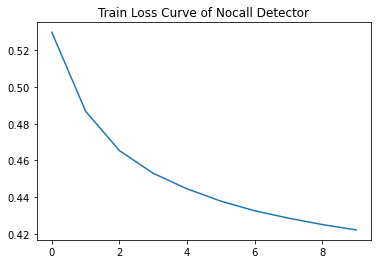

In [62]:
import matplotlib.pyplot as plt

train_losses = torch.tensor(train_losses, device = 'cpu')
plt.plot(np.arange(len(train_losses)), train_losses)
plt.title('Train Loss Curve of Nocall Detector')

C:\Users\ujubo\AppData\Local\Temp/ipykernel_15484/4126914523.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_losses = torch.tensor(val_losses, device = 'cpu')


Text(0.5, 1.0, 'Validation Accuracy Curve of Nocall Detector')

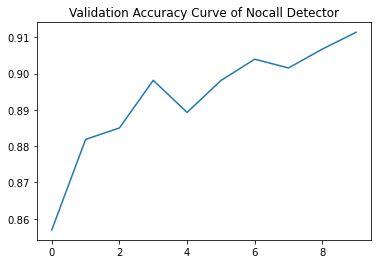

In [63]:
val_losses = torch.tensor(val_losses, device = 'cpu')
plt.plot(np.arange(len(val_losses)), val_losses)
plt.title('Validation Accuracy Curve of Nocall Detector')

C:\Users\ujubo\AppData\Local\Temp/ipykernel_15484/1290367574.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_scores = torch.tensor(log_scores, device = 'cpu')


Text(0.5, 1.0, 'Log-score Curve of Nocall Detector')

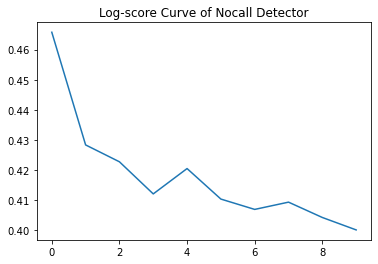

In [64]:
log_scores = torch.tensor(log_scores, device = 'cpu')
plt.plot(np.arange(len(log_scores)), log_scores)
plt.title('Log-score Curve of Nocall Detector')

C:\Users\ujubo\AppData\Local\Temp/ipykernel_15484/3035292173.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fbeta_scores = torch.tensor(fbeta_scores, device = 'cpu')


Text(0.5, 1.0, 'F-beta score Curve of Nocall Detector')

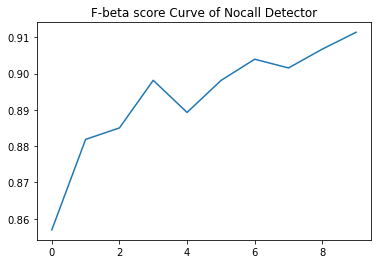

In [65]:
fbeta_scores = torch.tensor(fbeta_scores, device = 'cpu')
plt.plot(np.arange(len(fbeta_scores)), fbeta_scores)
plt.title('F-beta score Curve of Nocall Detector')

In [18]:
print('\nAccuracy: %.2f' % (100 * test_scores[0]))
print('Log Loss score:\t%.2f' % (test_scores[1]))
print('Fbeta-score (beta=1.0): \t%.2f' % (test_scores[2]))

NameError: name 'test_scores' is not defined

In [19]:
torch.save(cur_model.state_dict(), './nocall_detector.pt')

NameError: name 'cur_model' is not defined

In [ ]:
# test for ff1010 and birdclef with nocall_detector.pt is below

In [49]:
# Modify dataframe for K-Fold Cross Validation (birdclef2021)
birdclef_csv = pandas.read_csv(AudioImage_Path + 'train_metadata.csv')
birdclef_csv.loc[birdclef_csv['label_id'] >= 0,'filepath'] = \
    AudioImage_Path + birdclef_csv.query('label_id >= 0')['primary_label'] + '/' + \
    birdclef_csv.query('label_id >= 0')['filename'] + '.npy'

birdclef_csv = birdclef_csv.dropna()
birdclef_csv = birdclef_csv.reset_index(drop=True)

# Add 'fold' attribute for dataset classification
birdclef_dataframe = birdclef_csv.copy()
for n, (_, nth_groups) in enumerate(
    skf.split(birdclef_dataframe, birdclef_dataframe['label_id'])):
    birdclef_dataframe.loc[nth_groups, 'fold'] = int(n)

In [41]:
# Class for ff1010 dataset
class birdclef(Dataset):
    def __init__(self, dataframe, process='train', labels='label_id'):
        self.dataframe = dataframe
        self.filepaths = dataframe['filepath'].values
        self.labels = dataframe[labels].values
        self.process = process
        
        # Transforms for each train and validation
        self.train_transform = TT.Compose([
            TT.Resize([128, 281]),
            TT.RandomHorizontalFlip(p=0.5),
            TT.RandomVerticalFlip(p=0.5),
            TT.ToTensor(),
            TT.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])
        self.val_transform = TT.Compose([
            TT.Resize([128, 281]),
            TT.ToTensor(),
            TT.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])
    
    def __getitem__(self, idx):
        source = np.load(self.filepaths[idx])
        
        # Rearrange numpy arrays
        source = source.transpose(1, 2, 0)
        
        # Add RGB dimension
        source = np.stack((np.squeeze(source), ) * 3, -1)
        if len(source.shape) == 3:
            source = np.expand_dims(source, axis=2)
        source = source.transpose(2, 0, 1, 3)
        N, H, W, C = source.shape
        
        # Apply transform
        if self.process == 'train':
            source = torch.stack([self.train_transform(Image.fromarray(x)) for x in source])
        elif self.process == 'valid':
            source = torch.stack([self.val_transform(Image.fromarray(x)) for x in source])
        
        # Select the middle input from slices
        source = source[N // 2]

        return source, torch.tensor(self.labels[idx], dtype=ltype)
    
    def __len__(self):
        return len(self.dataframe)

In [42]:
class Model1(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.resnet50 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True).to(device)
        self.relu = nn.ReLU().to(device)
        self.linear = nn.Linear(1000, num_classes, bias=True).to(device)
    
    def forward (self, x):
        x = self.resnet50(x)
        x = self.relu(x)
        x = self.linear(x)
        return x

In [43]:
bnocall = Model1()
    
bnocall.load_state_dict(torch.load('./nocall_detector.pt'))


Using cache found in C:\Users\ujubo/.cache\torch\hub\pytorch_vision_v0.10.0


<All keys matched successfully>

In [44]:
def nocalltest(metadata, model):
    test_dataframe = metadata.query(
        'fold >= ' + str(0) 
    ).reset_index(drop=True)

    test_data = FF1010(test_dataframe, process='valid', labels='hasbird')

#source = np.load(test_data.filepaths[0])

#for x in source:
#    print(x.shape)

    test_loader = DataLoader(test_data, batch_size=32,
                            sampler=sampler.SubsetRandomSampler(range(len(test_dataframe))), 
                            drop_last=True)
    
    test_acc, test_log_score, test_fbeta_score = evaluate_model(test_loader, model, beta=1.0)
    
    print(test_acc)

In [51]:
def nocalltest2(metadata, model):
    test_dataframe = metadata.query(
        'fold >= ' + str(0) 
    ).reset_index(drop=True)

    test_data = birdclef(test_dataframe, process='valid', labels='hasbird')

#source = np.load(test_data.filepaths[0])

#for x in source:
#    print(x.shape)

    test_loader = DataLoader(test_data, batch_size=32,
                            sampler=sampler.SubsetRandomSampler(range(len(test_dataframe))), 
                            drop_last=True)
    
    test_acc, test_log_score, test_fbeta_score = evaluate_model(test_loader, model, beta=1.0)
    
    print(test_acc)

In [29]:
nocalltest(ff1010_csv, bnocall)

Checking accuracy score on validation set.

Accuracy: 9236 / 10080 correct (91.63)
Log Loss score:	0.51
Fbeta-score (beta=1): 	0.92
0.9162698412698412


In [46]:
nocalltest2(birdclef_csv, bnocall)

Checking accuracy score on validation set.

Accuracy: 59133 / 62848 correct (94.09)
Log Loss score:	0.23
Fbeta-score (beta=1): 	0.94
0.9408891293279023
